In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
file_path = 'C:/Users/spheres/Downloads/Unwashed MXene probe son (1 mg per mL).xlsx'
df = pd.read_excel(file_path)

df

,-69.41677,-5.80000
0,-66.781802,5.5
1,-64.147570,-7.0
2,-61.514073,3.4
3,-58.883481,5.8
4,-56.253623,-8.0
...,...,...
2042,3441.677919,21.6
2043,3442.690017,11.7
2044,3443.700543,9.5
2045,3444.709500,31.3


In [4]:
column_headers = ['Wavenumber'] + ['Intensity']

df.columns = column_headers

In [5]:
df.dropna()

,Wavenumber,Intensity
0,-66.781802,5.5
1,-64.147570,-7.0
2,-61.514073,3.4
3,-58.883481,5.8
4,-56.253623,-8.0
...,...,...
2042,3441.677919,21.6
2043,3442.690017,11.7
2044,3443.700543,9.5
2045,3444.709500,31.3


In [6]:
df = df.drop(index = 0)
df = df[df['Wavenumber'] >= 0]
df = df[30:].reset_index(drop=True)


df = df.copy()

df = df.reset_index()
df = df.drop(columns = 'index')

df

,Wavenumber,Intensity
0,78.905287,0.7
1,81.475476,2.4
2,84.042824,-9.4
3,86.609467,1.7
4,89.171137,17.9
...,...,...
1986,3441.677919,21.6
1987,3442.690017,11.7
1988,3443.700543,9.5
1989,3444.709500,31.3


In [7]:
num_frames = df.shape[1] -1
num_data_points = df.shape[0]
print(num_data_points)
print(num_frames)

1991
1


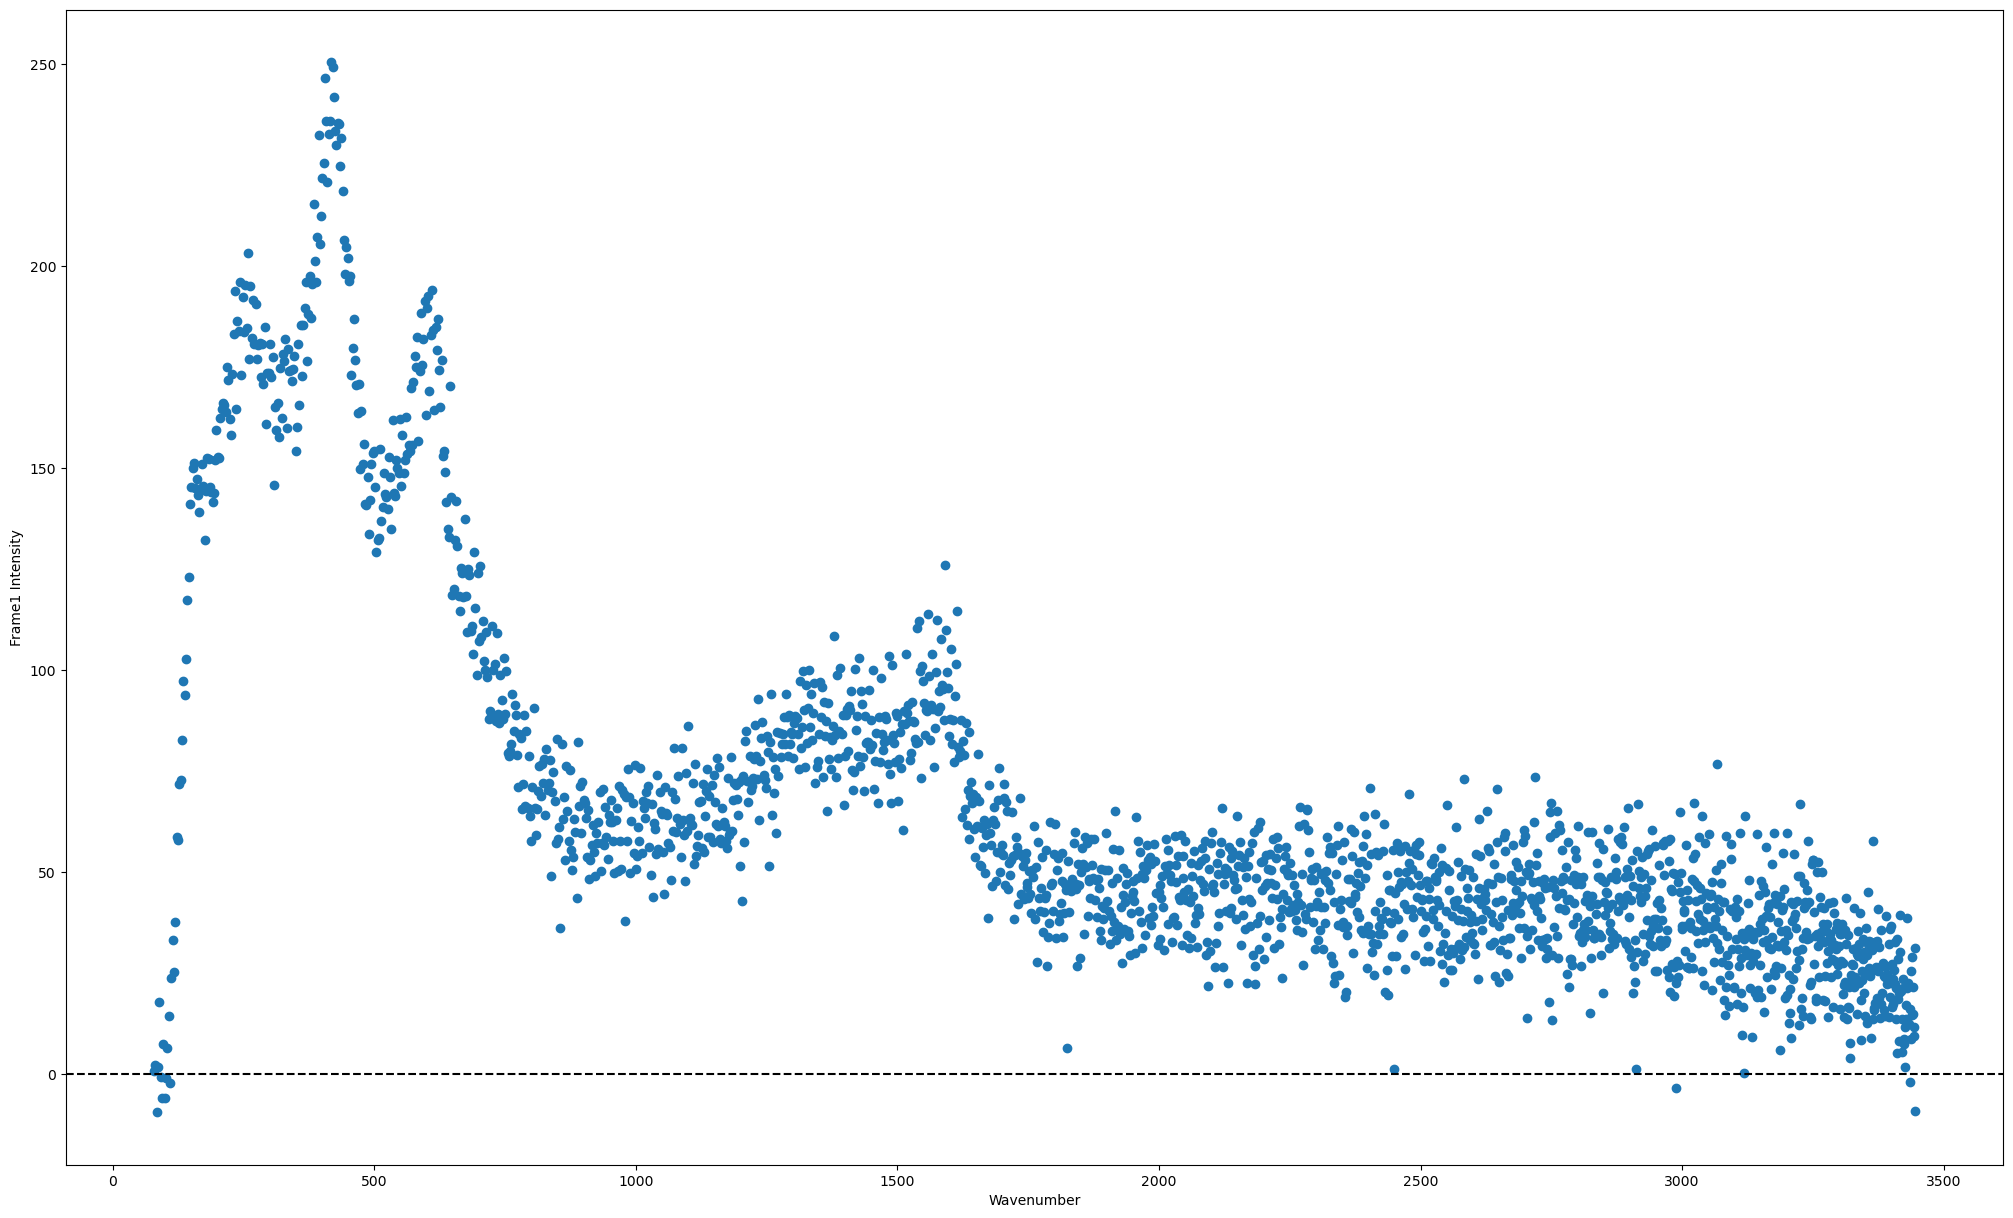

In [8]:
df=df.copy()
df = df[df['Wavenumber'] >= 0]
plt.figure(figsize=(25, 15))
plt.scatter(df['Wavenumber'], df['Intensity'], label='Frame1')

plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Wavenumber')
plt.ylabel('Frame1 Intensity')

plt.show()

In [9]:
from scipy import sparse
from scipy.linalg import cholesky
from scipy.sparse.linalg import spsolve

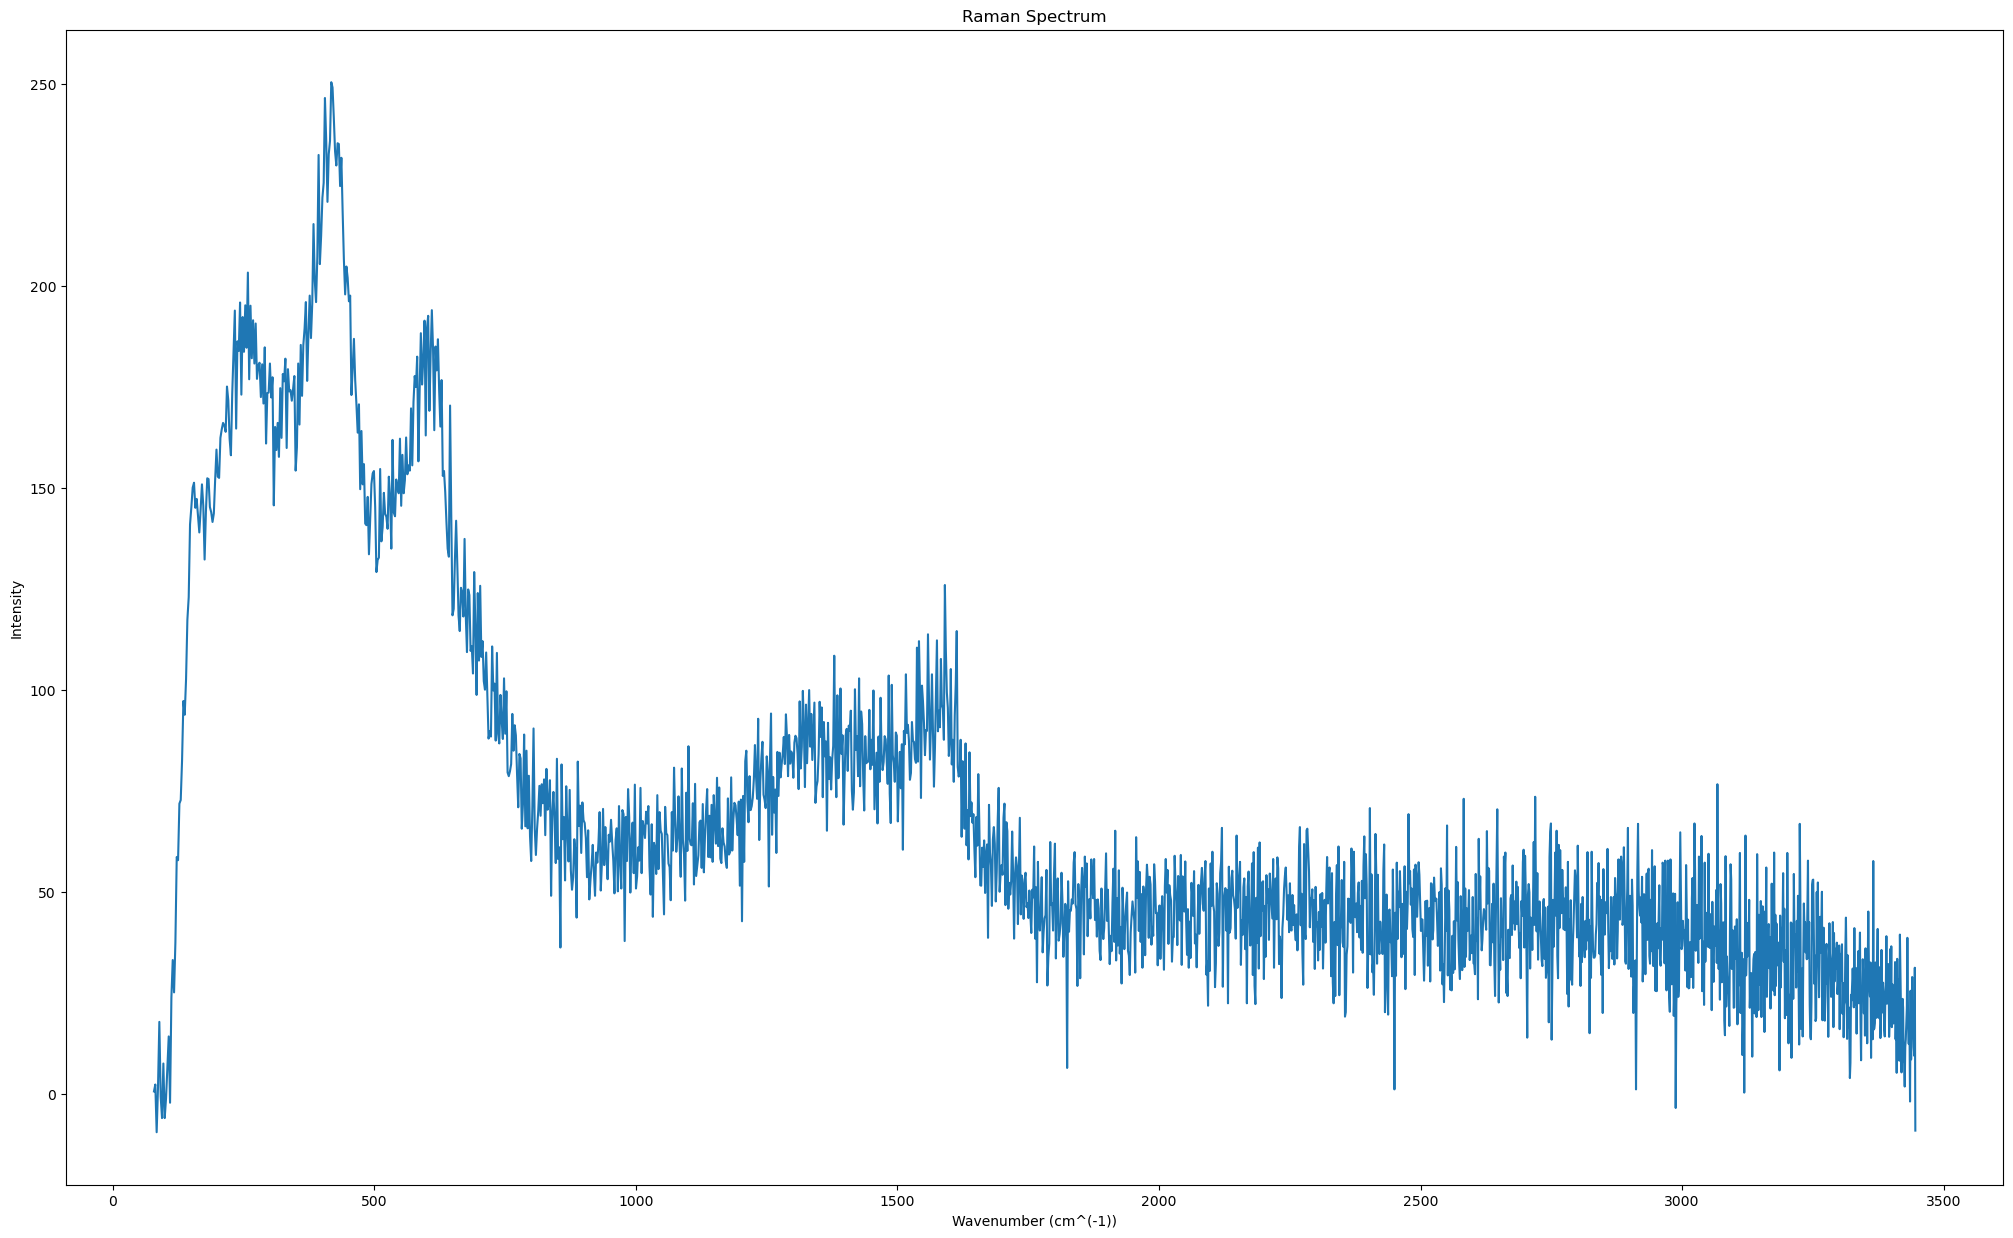

In [10]:
wn = np.array(df['Wavenumber'])
raman = np.array(df['Intensity'])

plt.figure(figsize=(25,15))
plt.plot(wn, raman)
plt.xlabel("Wavenumber (cm^(-1))")
plt.ylabel("Intensity")
plt.title("Raman Spectrum")
plt.show()

In [11]:
def als(y, lam=1000000, p=0.1, itermax=10):
    r"""
    Implements an Asymmetric Least Squares Smoothing
    baseline correction algorithm (P. Eilers, H. Boelens 2005)
 
    Baseline Correction with Asymmetric Least Squares Smoothing
    based on https://web.archive.org/web/20200914144852/https://github.com/vicngtor/BaySpecPlots
 
    Baseline Correction with Asymmetric Least Squares Smoothing
    Paul H. C. Eilers and Hans F.M. Boelens
    October 21, 2005
 
    Description from the original documentation:
 
    Most baseline problems in instrumental methods are characterized by a smooth
    baseline and a superimposed signal that carries the analytical information: a series
    of peaks that are either all positive or all negative. We combine a smoother
    with asymmetric weighting of deviations from the (smooth) trend get an effective
    baseline estimator. It is easy to use, fast and keeps the analytical peak signal intact.
    No prior information about peak shapes or baseline (polynomial) is needed
    by the method. The performance is illustrated by simulation and applications to
    real data.
 
    Inputs:
        y:
            input data (i.e. chromatogram of spectrum)
        lam:
            parameter that can be adjusted by user. The larger lambda is,
            the smoother the resulting background, z
        p:
            weighting deviations. 0.5 = symmetric, <0.5: negative
            deviations are stronger suppressed
        itermax:
            number of iterations to perform
    Output:
        the fitted background vector
 
    """
    L = len(y)
    D = sparse.eye(L, format='csc')
    D = D[1:] - D[:-1]
    D = D[1:] - D[:-1]
    D = D.T
    w = np.ones(L)
    for i in range(itermax):
        W = sparse.diags(w, 0, shape=(L, L))
        Z = W + lam * D.dot(D.T)
        z = spsolve(Z, w * y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z

In [12]:
def arpls(y, lam=10000, ratio=0.05, itermax=100):
    r"""
    Baseline correction using asymmetrically
    reweighted penalized least squares smoothing
    Sung-June Baek, Aaron Park, Young-Jin Ahna and Jaebum Choo,
    Analyst, 2015, 140, 250 (2015)
 
    Abstract
 
    Baseline correction methods based on penalized least squares are successfully
    applied to various spectral analyses. The methods change the weights iteratively
    by estimating a baseline. If a signal is below a previously fitted baseline,
    large weight is given. On the other hand, no weight or small weight is given
    when a signal is above a fitted baseline as it could be assumed to be a part
    of the peak. As noise is distributed above the baseline as well as below the
    baseline, however, it is desirable to give the same or similar weights in
    either case. For the purpose, we propose a new weighting scheme based on the
    generalized logistic function. The proposed method estimates the noise level
    iteratively and adjusts the weights correspondingly. According to the
    experimental results with simulated spectra and measured Raman spectra, the
    proposed method outperforms the existing methods for baseline correction and
    peak height estimation.
 
    Inputs:
        y:
            input data (i.e. chromatogram of spectrum)
        lam:
            parameter that can be adjusted by user. The larger lambda is,
            the smoother the resulting background, z
        ratio:
            weighting deviations: 0 < ratio < 1, smaller values allow less negative values
        itermax:
            number of iterations to perform
    Output:
        the fitted background vector
 
    """
    N = len(y)
    D = sparse.eye(N, format='csc')
    D = D[1:] - D[:-1]
    D = D[1:] - D[:-1]
 
    H = lam * D.T * D
    w = np.ones(N)
    for i in range(itermax):
        W = sparse.diags(w, 0, shape=(N, N))
        WH = sparse.csc_matrix(W + H)
        C = sparse.csc_matrix(cholesky(WH.todense()))
        z = spsolve(C, spsolve(C.T, w * y))
        d = y - z
        dn = d[d < 0]
        m = np.mean(dn)
        s = np.std(dn)
        wt = 1. / (1 + np.exp(2 * (d - (2 * s - m)) / s))
        if np.linalg.norm(w - wt) / np.linalg.norm(w) < ratio:
            break
        w = wt
    return z

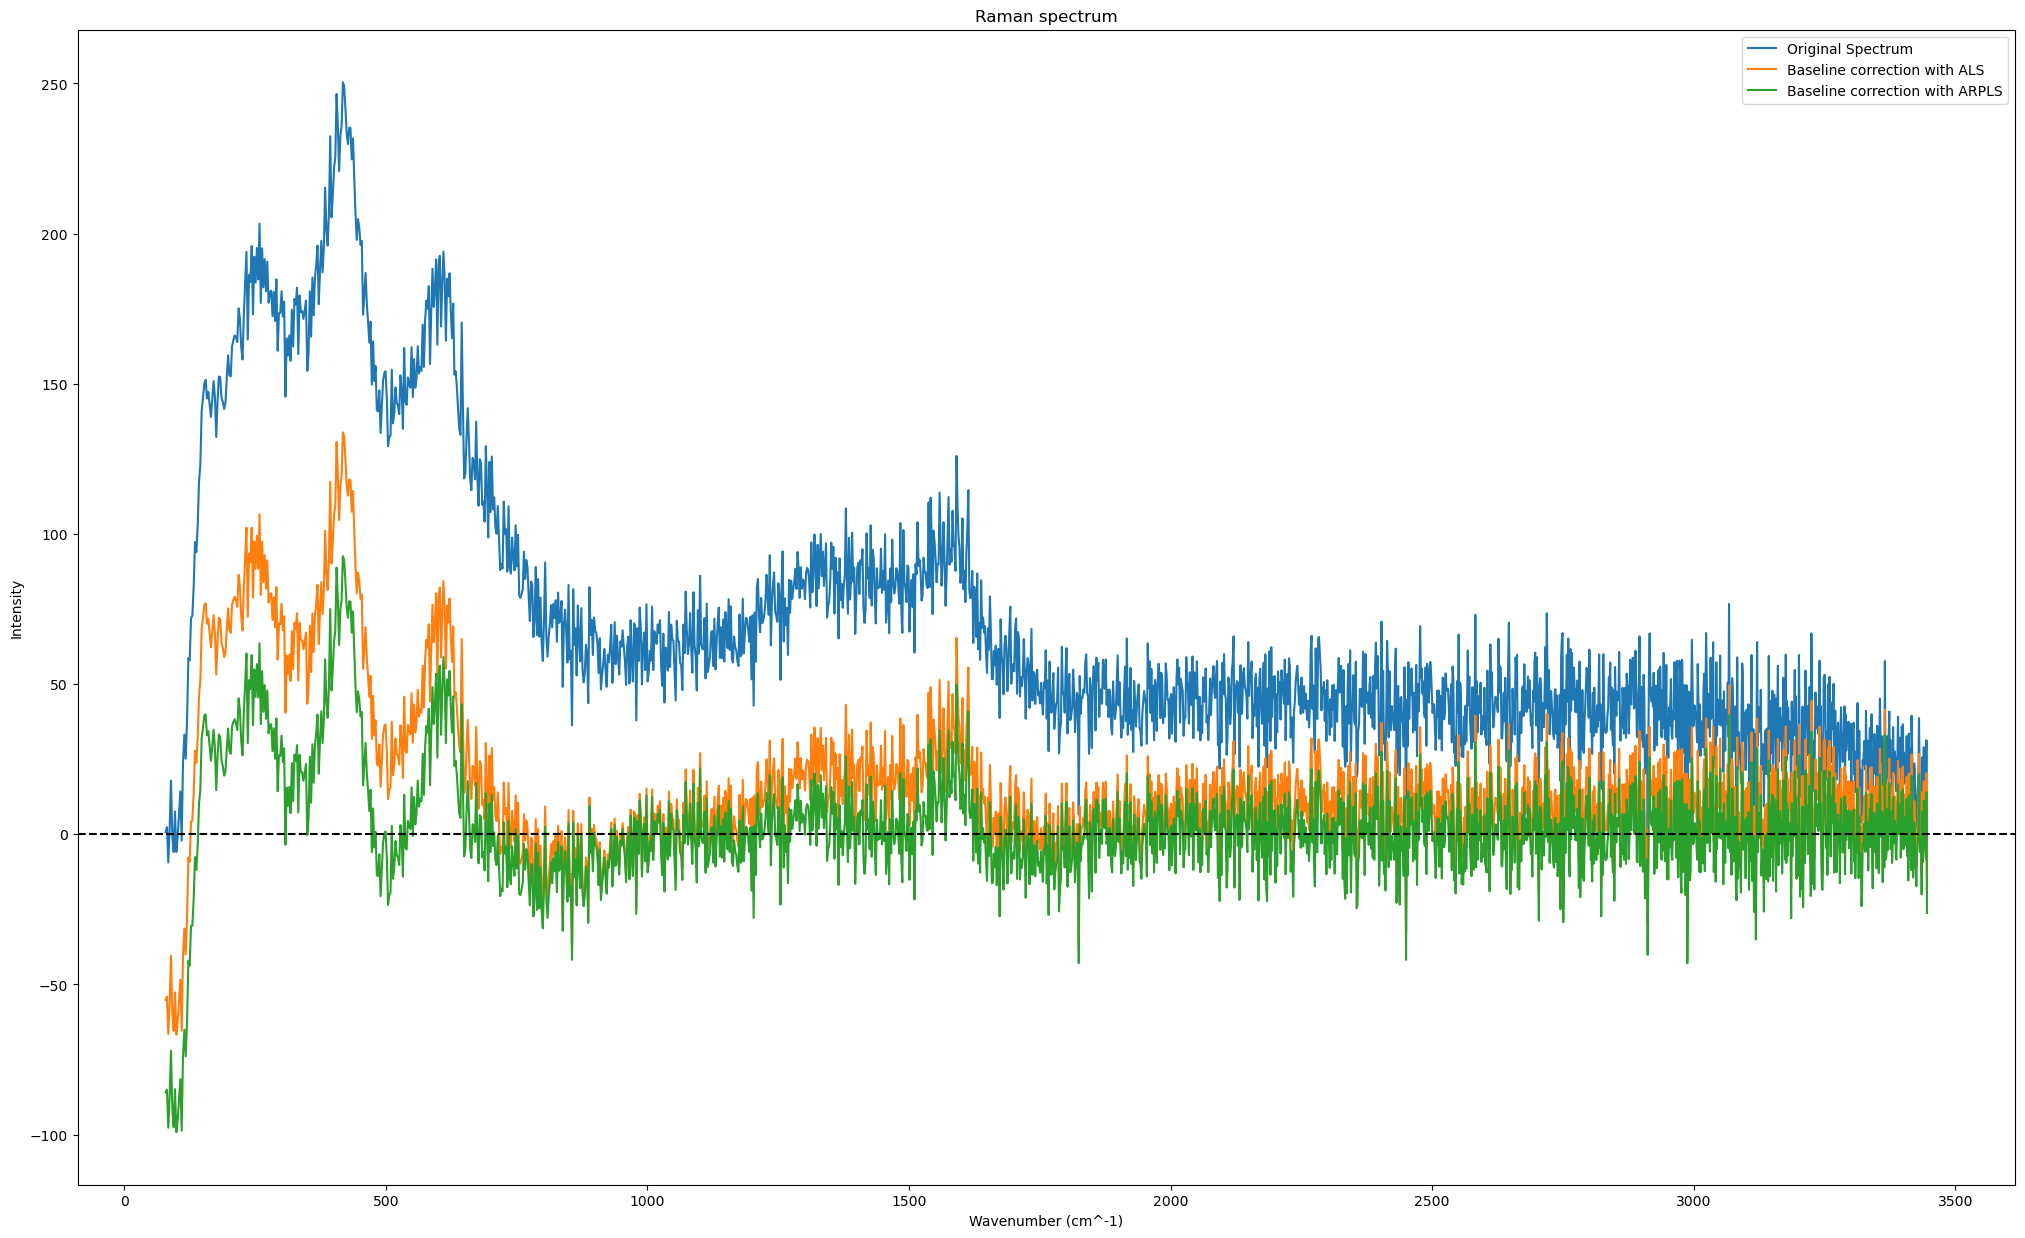

In [13]:
baseline_als_raman = als(raman, lam=10000000, itermax=5)
baseline_arpls_raman = arpls(raman, lam=10000000, itermax=5)

plt.figure(figsize=(25,15))
plt.plot(wn, raman, label = 'Original Spectrum')
plt.plot(wn, raman - baseline_als_raman, label = 'Baseline correction with ALS')
plt.plot(wn, raman - baseline_arpls_raman, label = 'Baseline correction with ARPLS')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Wavenumber (cm^-1)")
plt.ylabel("Intensity")
plt.title("Raman spectrum")
plt.legend()
plt.show()

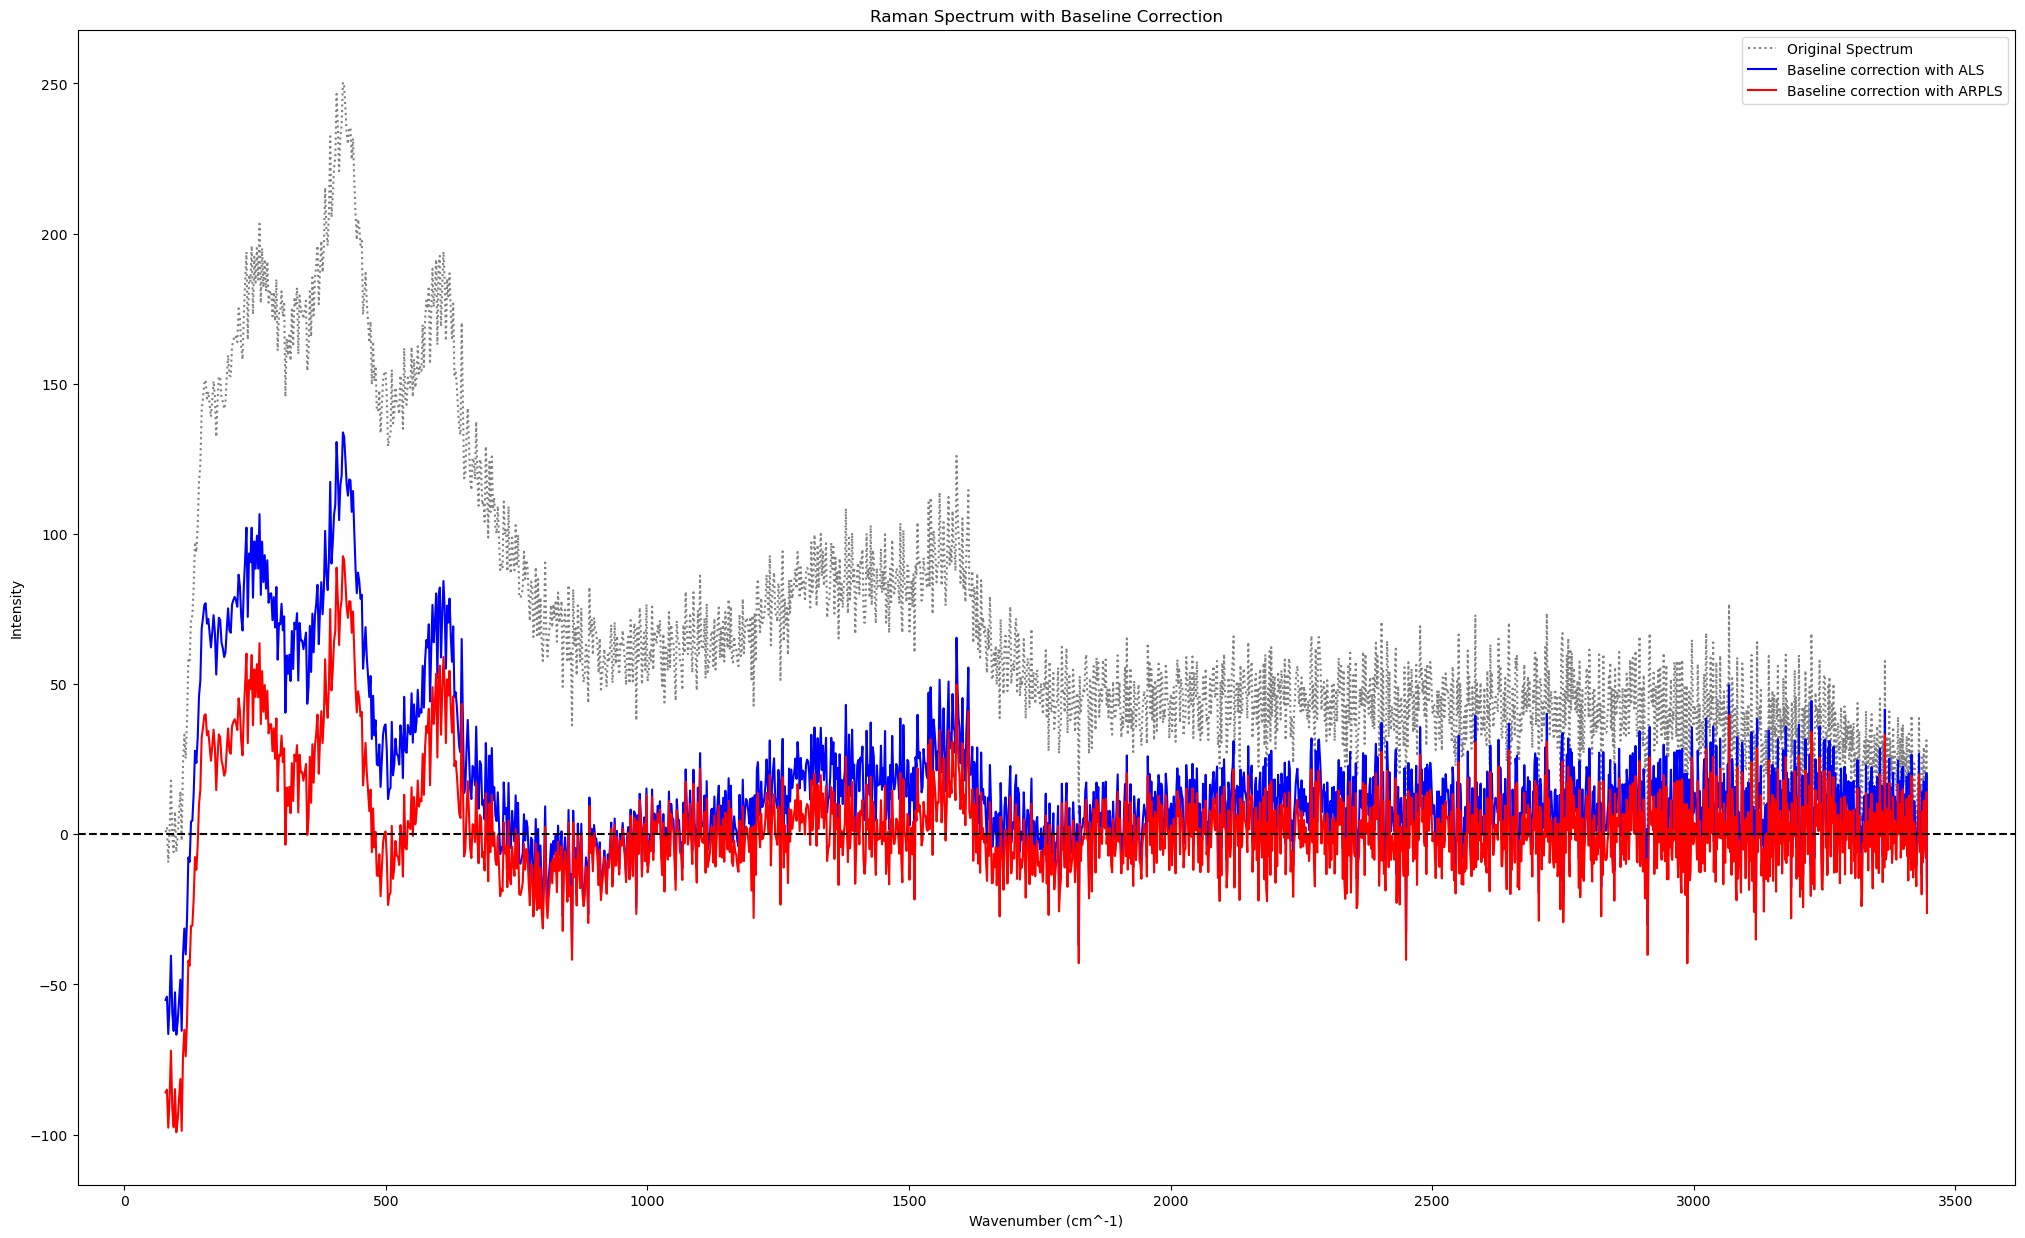

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.linalg import cholesky

def als(y, lam=1000000, p=0.1, itermax=10):
    L = len(y)
    D = sparse.eye(L, format='csc')
    D = D[1:] - D[:-1] 
    D = D[1:] - D[:-1]
    D = D.T
    w = np.ones(L)
    for i in range(itermax):
        W = sparse.diags(w, 0, shape=(L, L))
        Z = W + lam * D.dot(D.T)
        z = spsolve(Z, w * y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z

def arpls(y, lam=10000, ratio=0.05, itermax=100):
    N = len(y)
    D = sparse.eye(N, format='csc')
    D = D[1:] - D[:-1]  
    D = D[1:] - D[:-1]
    H = lam * D.T * D
    w = np.ones(N)
    for i in range(itermax):
        W = sparse.diags(w, 0, shape=(N, N))
        WH = sparse.csc_matrix(W + H)
        C = sparse.csc_matrix(cholesky(WH.todense()))
        z = spsolve(C, spsolve(C.T, w * y))
        d = y - z
        dn = d[d < 0]
        m = np.mean(dn)
        s = np.std(dn)
        wt = 1. / (1 + np.exp(2 * (d - (2 * s - m)) / s))
        if np.linalg.norm(w - wt) / np.linalg.norm(w) < ratio:
            break
        w = wt
    return z

wn = np.array(df['Wavenumber'])  
raman = np.array(df['Intensity']) 

baseline_als_raman = als(raman, lam=10000000, itermax=5)
baseline_arpls_raman = arpls(raman, lam=10000000, itermax=5)

plt.figure(figsize=(25, 15))
plt.plot(wn, raman, label='Original Spectrum', color='gray', linestyle="dotted")
plt.plot(wn, raman - baseline_als_raman, label='Baseline correction with ALS', color='blue')
plt.plot(wn, raman - baseline_arpls_raman, label='Baseline correction with ARPLS', color='red')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Wavenumber (cm^-1)")
plt.ylabel("Intensity")
plt.title("Raman Spectrum with Baseline Correction")
plt.legend()
plt.show()


In [15]:
df['Intensity_ALS_Corrected'] = raman - baseline_als_raman
df['Intensity_ARPLS_Corrected'] = raman - baseline_arpls_raman

from scipy.signal import savgol_filter

df['Intensity_ALS_Smoothed'] = savgol_filter(df['Intensity_ALS_Corrected'], window_length=25, polyorder=3)
df['Intensity_ARPLS_Smoothed'] = savgol_filter(df['Intensity_ARPLS_Corrected'], window_length=25, polyorder=3)

df_als = df[['Wavenumber', 'Intensity_ALS_Corrected']].copy()
df_arpls = df[['Wavenumber', 'Intensity_ARPLS_Corrected']].copy()

In [16]:
df_als

,Wavenumber,Intensity_ALS_Corrected
0,78.905287,-55.143520
1,81.475476,-54.066693
2,84.042824,-66.489861
3,86.609467,-56.013014
4,89.171137,-40.436136
...,...,...
1986,3441.677919,10.442658
1987,3442.690017,0.613204
1988,3443.700543,-1.516244
1989,3444.709500,20.354310


In [17]:
df_arpls

,Wavenumber,Intensity_ARPLS_Corrected
0,78.905287,-85.910269
1,81.475476,-85.044969
2,84.042824,-97.679661
3,86.609467,-87.414328
4,89.171137,-72.048942
...,...,...
1986,3441.677919,4.006281
1987,3442.690017,-5.794356
1988,3443.700543,-7.894987
1989,3444.709500,14.004386


In [18]:
df_als = df_als.rename(columns={'Intensity_ALS_Corrected': 'Intensity'})
df_arpls = df_arpls.rename(columns={'Intensity_ARPLS_Corrected': 'Intensity'})

from scipy.signal import savgol_filter

print(df_als.head())
print(df_arpls.head())

   Wavenumber  Intensity
0   78.905287 -55.143520
1   81.475476 -54.066693
2   84.042824 -66.489861
3   86.609467 -56.013014
4   89.171137 -40.436136
   Wavenumber  Intensity
0   78.905287 -85.910269
1   81.475476 -85.044969
2   84.042824 -97.679661
3   86.609467 -87.414328
4   89.171137 -72.048942


In [19]:
from scipy.special import wofz

def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def lorentzian(x, A, mu, gamma):
    return A / (1 + ((x - mu) / gamma)**2)

def voigt(x, A, mu, sigma, gamma):
    z = ((x - mu) + 1j * gamma) / (sigma * np.sqrt(2)) 
    return A * np.real(wofz(z))

In [20]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

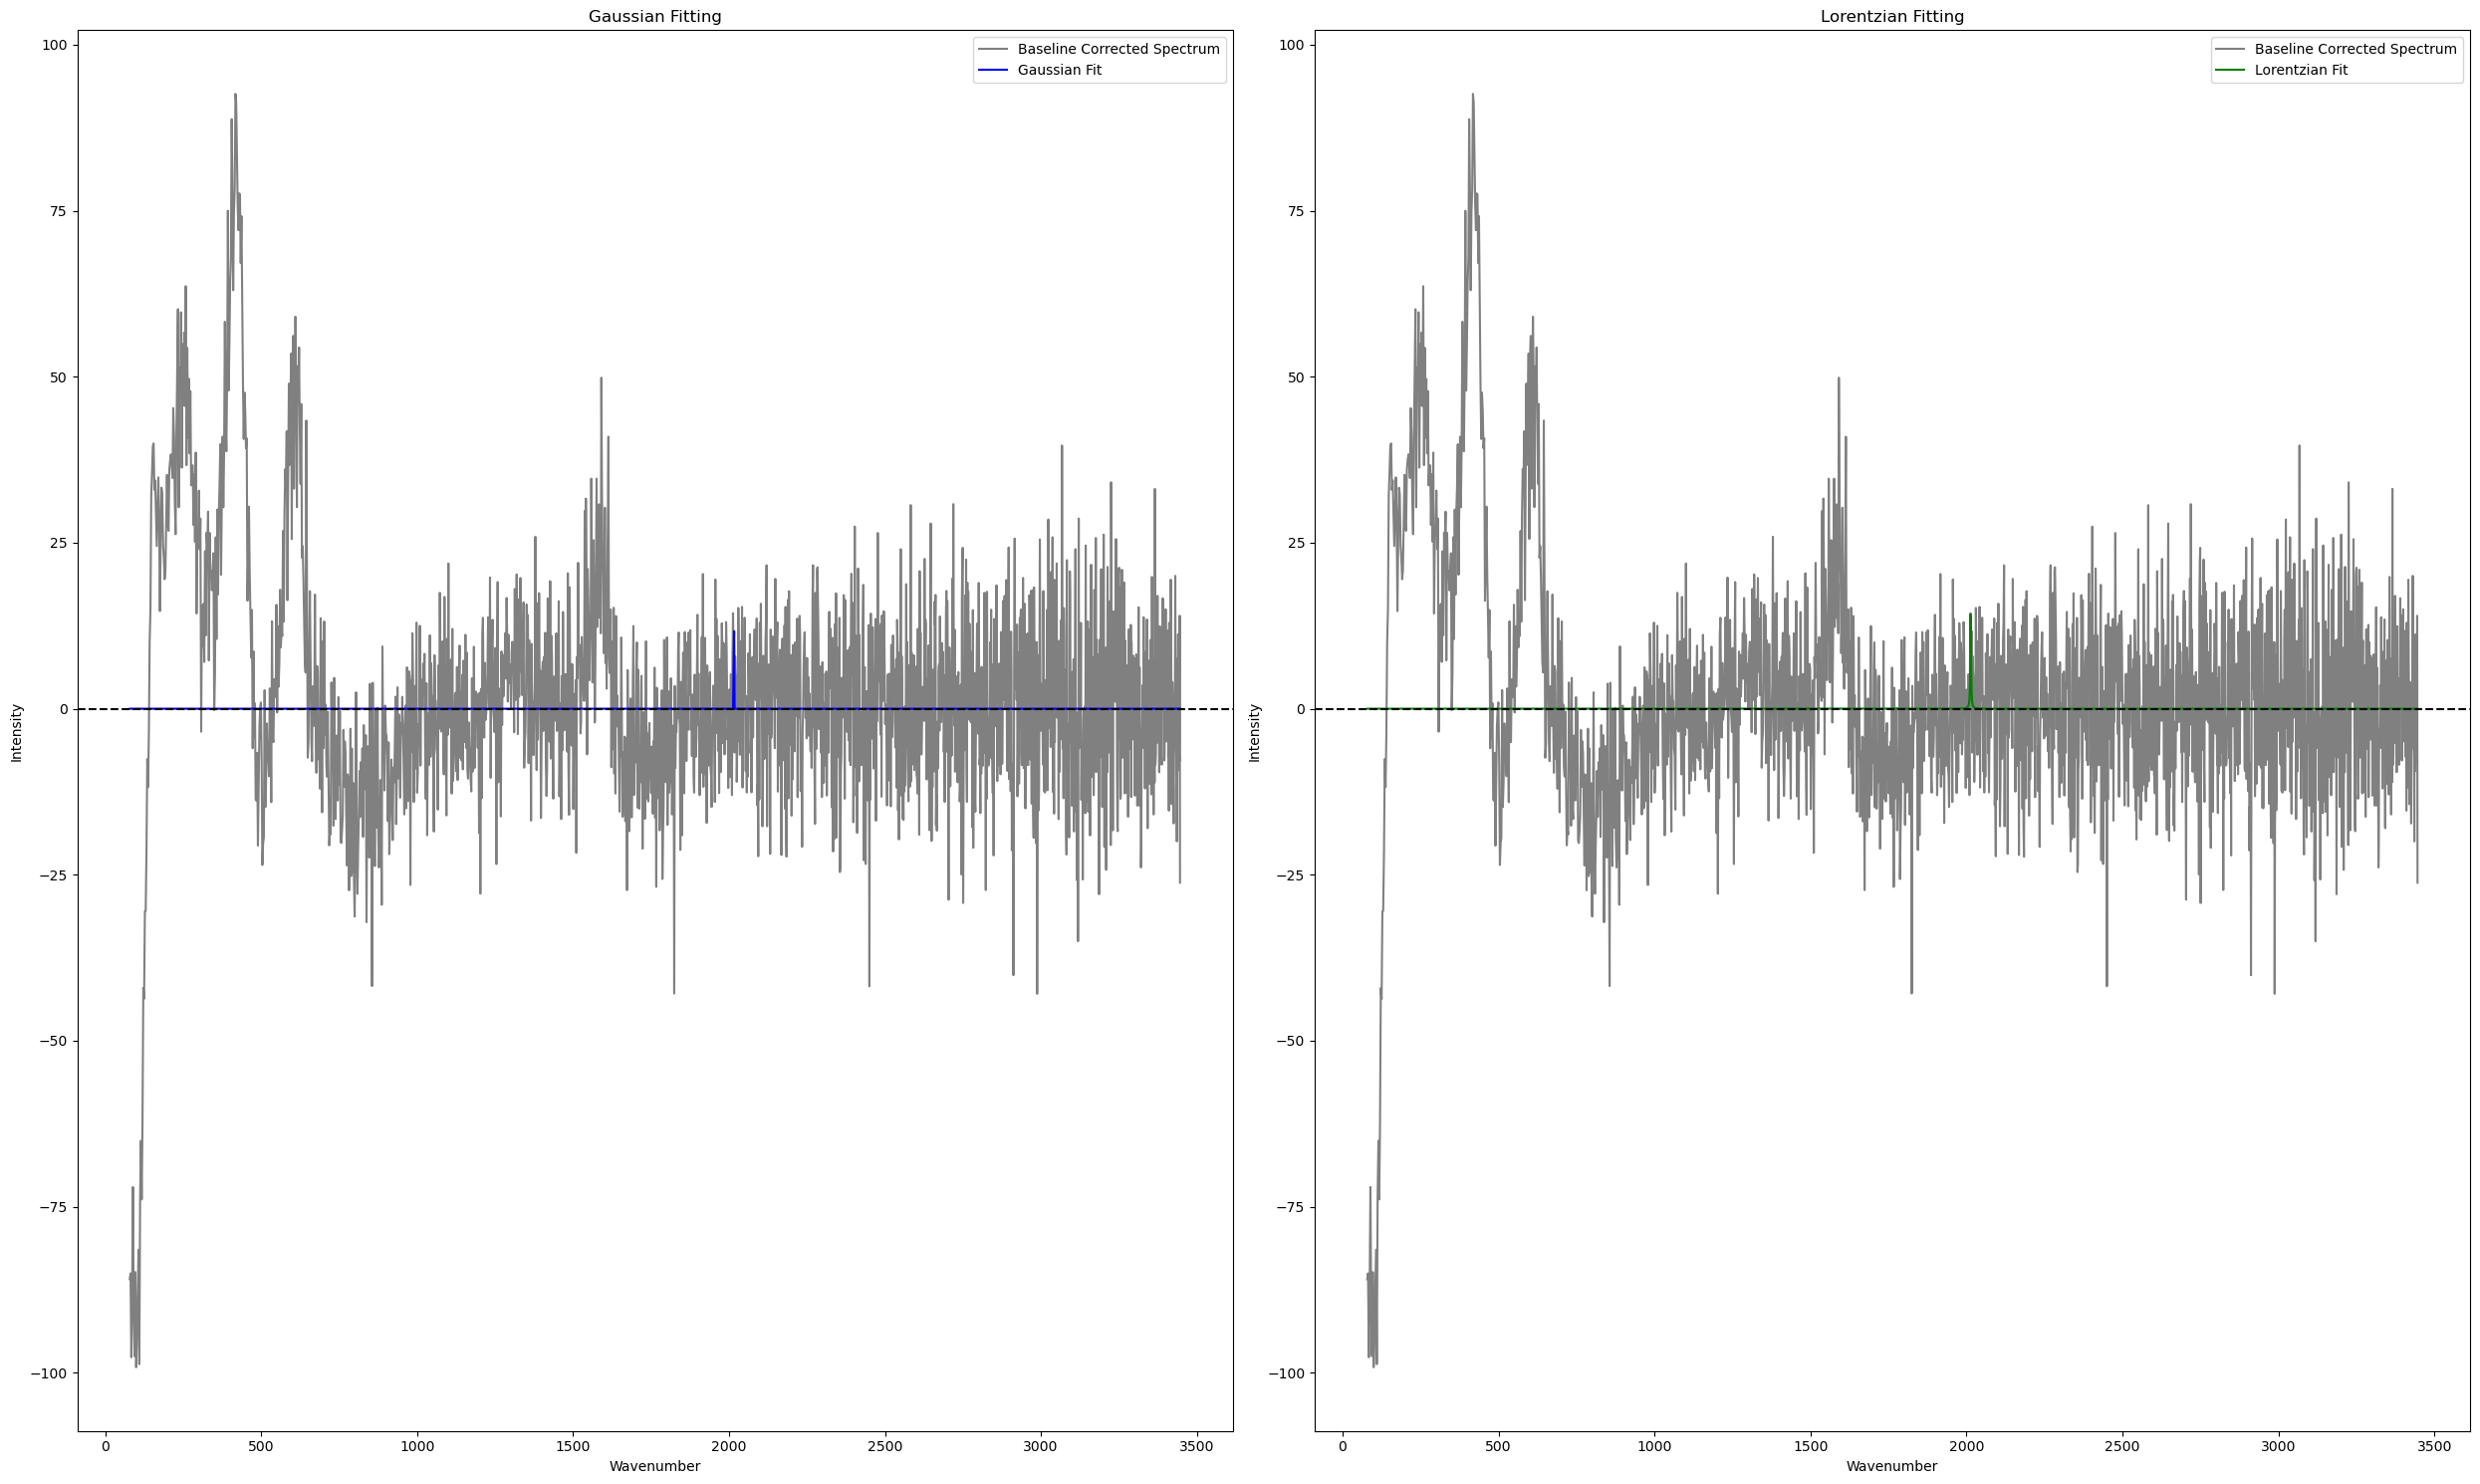

In [21]:
from scipy.optimize import curve_fit

df_test_GL = df_arpls.copy()

df_test_GL = df_test_GL[['Wavenumber', 'Intensity']]

p0_gaussian = [np.max(df_test_GL['Intensity']), np.mean(df_test_GL['Wavenumber']), 1]
p0_lorentzian = [np.max(df_test_GL['Intensity']), np.mean(df_test_GL['Wavenumber']), 1]

bounds = ([0, min(df_test_GL['Wavenumber']), 0], [np.inf, max(df_test_GL['Wavenumber']), np.inf])

params_gaussian, _ = curve_fit(gaussian, df_test_GL['Wavenumber'], df_test_GL['Intensity'], p0=p0_gaussian, bounds=bounds, maxfev=800)

params_lorentzian, _ = curve_fit(lorentzian, df_test_GL['Wavenumber'], df_test_GL['Intensity'], p0=p0_lorentzian, bounds=bounds, maxfev=800)

fitted_gaussian = gaussian(df_test_GL['Wavenumber'], *params_gaussian)
fitted_lorentzian = lorentzian(df_test_GL['Wavenumber'], *params_lorentzian)

fig, axes = plt.subplots(1, 2, figsize=(25, 15))

axes[0].plot(df_test_GL['Wavenumber'], df_test_GL['Intensity'], color='gray', label='Baseline Corrected Spectrum')
axes[0].plot(df_test_GL['Wavenumber'], fitted_gaussian, color='blue', label='Gaussian Fit')
axes[0].set_xlabel('Wavenumber')
axes[0].set_ylabel('Intensity')
axes[0].legend()
axes[0].axhline(0, color='black', linestyle='--')
axes[0].set_title('Gaussian Fitting')

axes[1].plot(df_test_GL['Wavenumber'], df_test_GL['Intensity'], color='gray', label='Baseline Corrected Spectrum')
axes[1].plot(df_test_GL['Wavenumber'], fitted_lorentzian, color='green', label='Lorentzian Fit')
axes[1].set_xlabel('Wavenumber')
axes[1].set_ylabel('Intensity')
axes[1].legend()
axes[1].axhline(0, color='black', linestyle='--')
axes[1].set_title('Lorentzian Fitting')

plt.tight_layout()
plt.show()

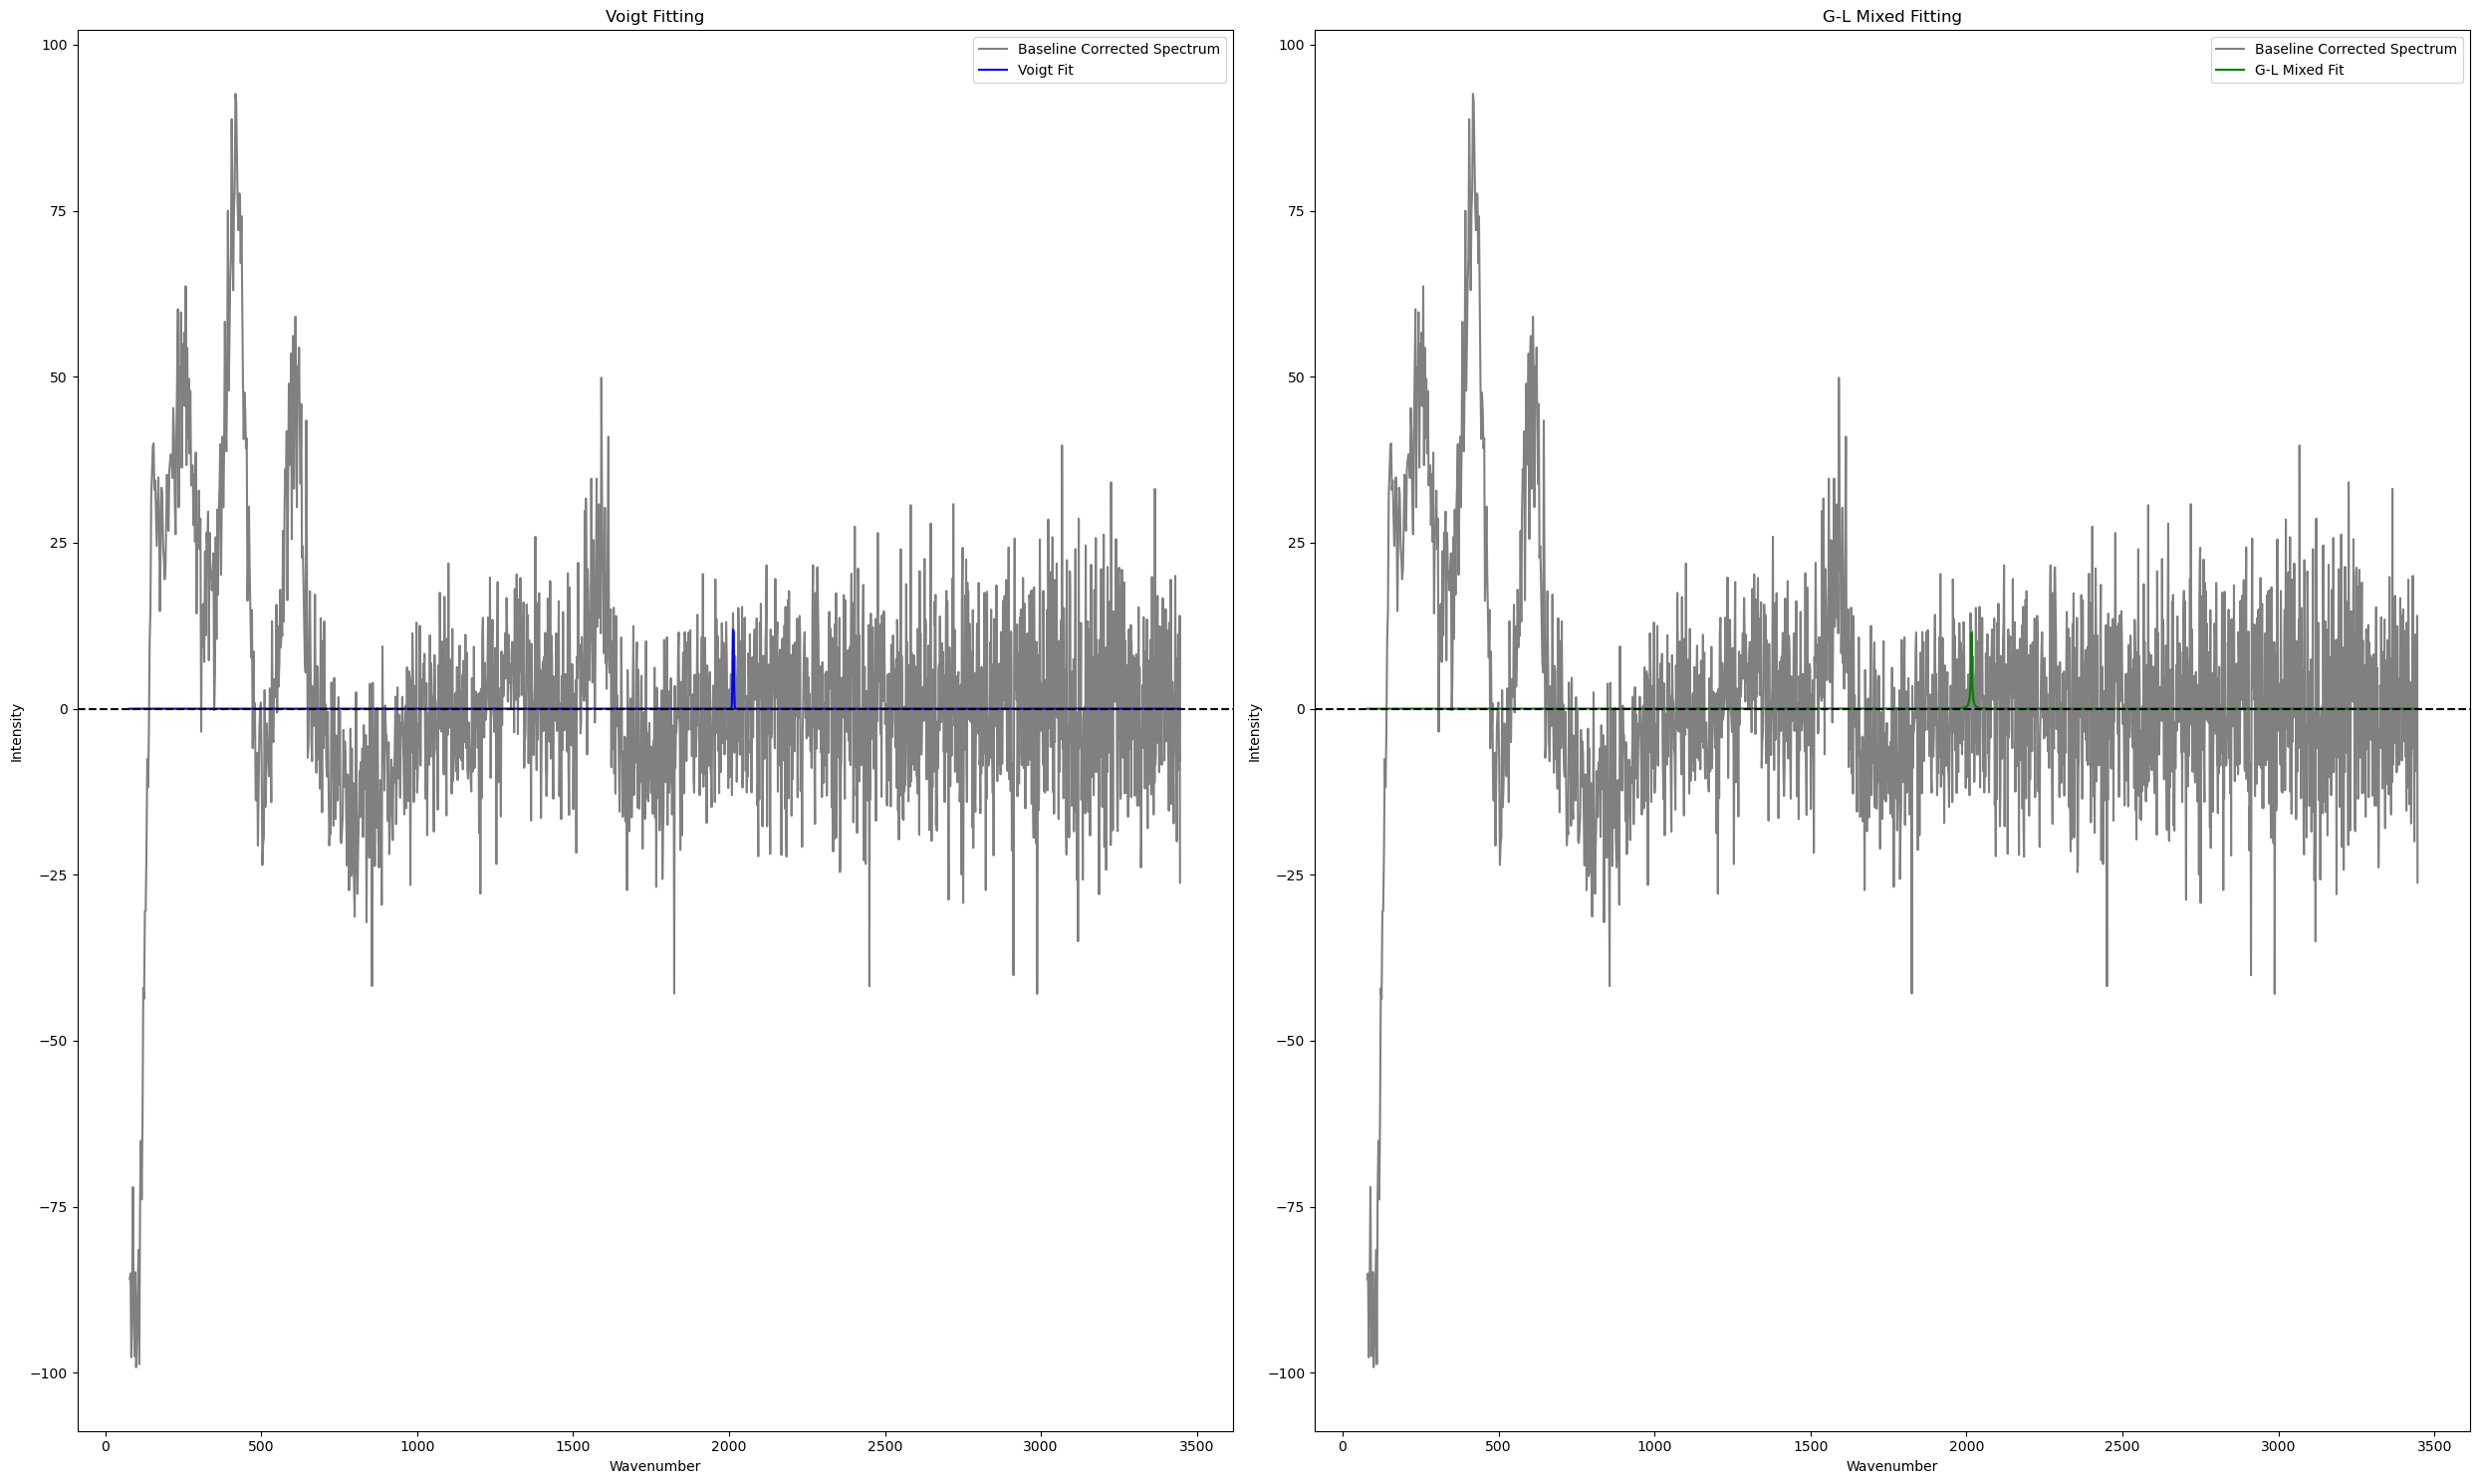

In [22]:
df_test_VGL = df_arpls.copy()

df_test_VGL = df_test_VGL[['Wavenumber', 'Intensity']]

p0_voigt = [np.max(df_test_VGL['Intensity']), np.mean(df_test_VGL['Wavenumber']), 1, 1]
p0_gl_mixed = [np.max(df_test_VGL['Intensity']), np.mean(df_test_VGL['Wavenumber']), 1, 1, 0.5]

bounds_voigt = ([0, min(df_test_VGL['Wavenumber']), 0, 0], [np.inf, max(df_test_VGL['Wavenumber']), np.inf, np.inf])
bounds_gl_mixed = ([0, min(df_test_VGL['Wavenumber']), 0, 0, 0], [np.inf, max(df_test_VGL['Wavenumber']), np.inf, np.inf, 1])

params_voigt, _ = curve_fit(voigt, df_test_VGL['Wavenumber'], df_test_VGL['Intensity'], p0=p0_voigt, bounds=bounds_voigt, maxfev=10000)

params_gl_mixed, _ = curve_fit(gl_mixed, df_test_VGL['Wavenumber'], df_test_VGL['Intensity'], p0=p0_gl_mixed, bounds=bounds_gl_mixed, maxfev=10000)

fitted_voigt = voigt(df_test_VGL['Wavenumber'], *params_voigt)
fitted_gl_mixed = gl_mixed(df_test_VGL['Wavenumber'], *params_gl_mixed)

fig, axes = plt.subplots(1, 2, figsize=(25, 15))

axes[0].plot(df_test_VGL['Wavenumber'], df_test_VGL['Intensity'], color='gray', label='Baseline Corrected Spectrum')
axes[0].plot(df_test_VGL['Wavenumber'], fitted_voigt, color='blue', label='Voigt Fit')
axes[0].set_xlabel('Wavenumber')
axes[0].set_ylabel('Intensity')
axes[0].legend()
axes[0].axhline(0, color='black', linestyle='--')
axes[0].set_title('Voigt Fitting')

axes[1].plot(df_test_VGL['Wavenumber'], df_test_VGL['Intensity'], color='gray', label='Baseline Corrected Spectrum')
axes[1].plot(df_test_VGL['Wavenumber'], fitted_gl_mixed, color='green', label='G-L Mixed Fit')
axes[1].set_xlabel('Wavenumber')
axes[1].set_ylabel('Intensity')
axes[1].legend()
axes[1].axhline(0, color='black', linestyle='--')
axes[1].set_title('G-L Mixed Fitting')

plt.tight_layout()
plt.show()

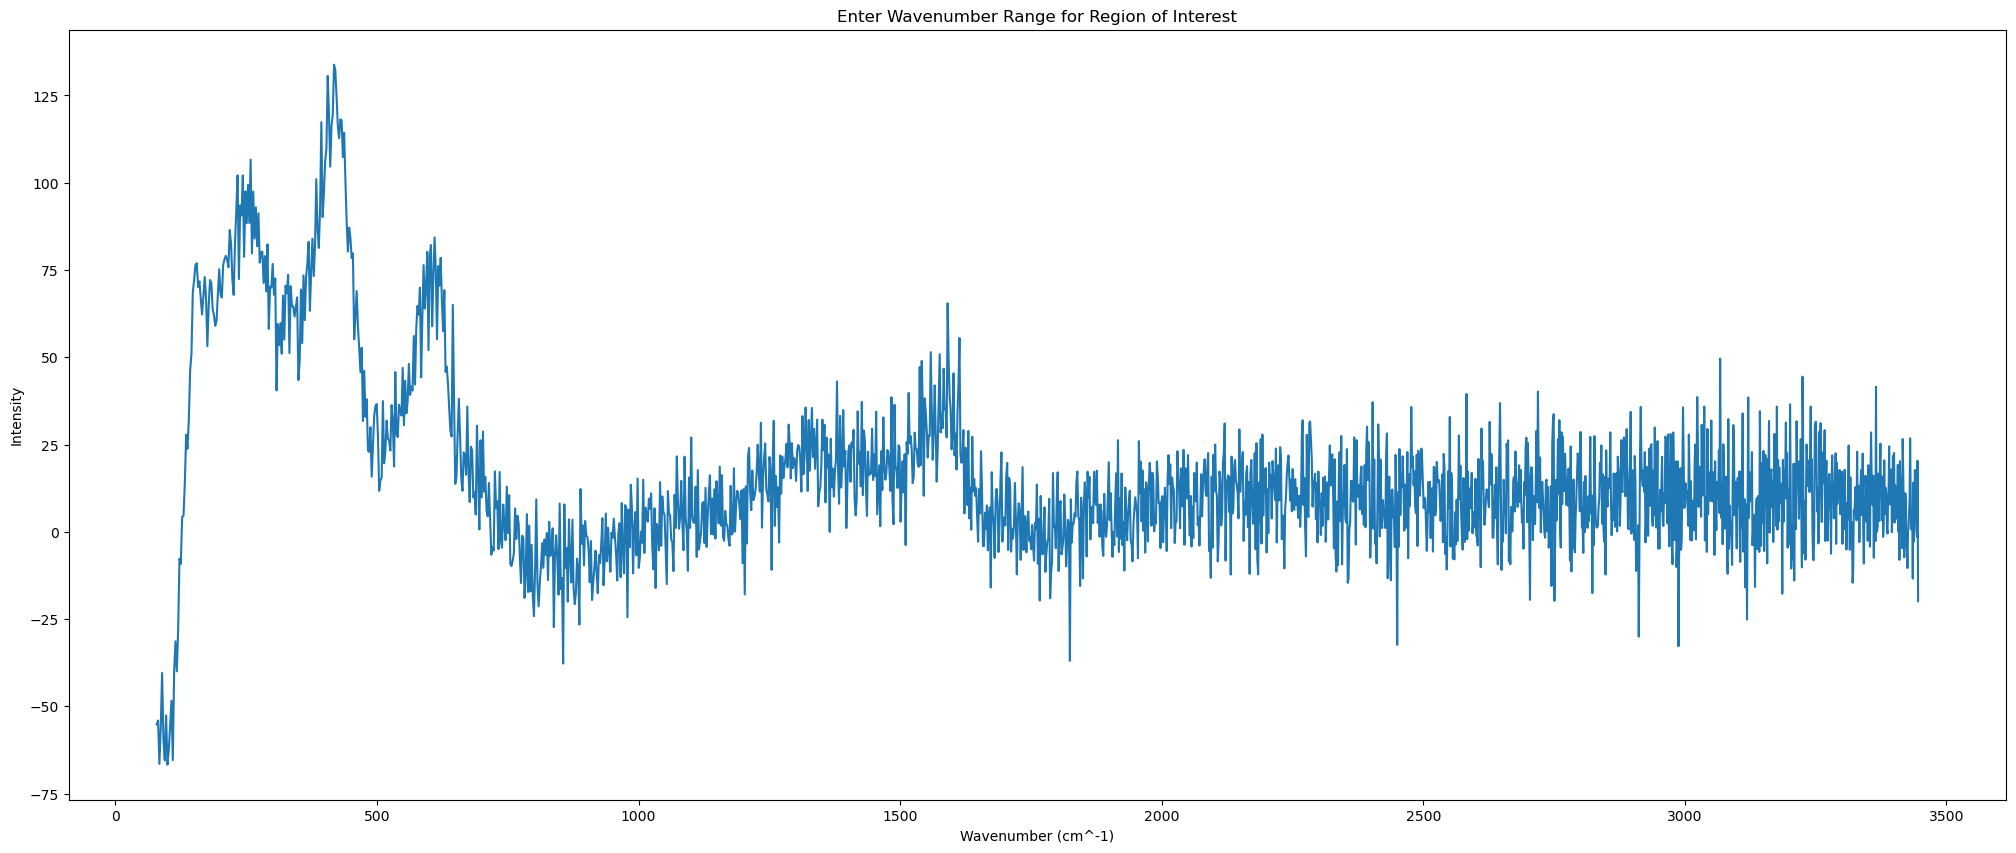

Enter the start wavenumber of the region of interest (e.g., 1200): 500
Enter the end wavenumber of the region of interest (e.g., 1600): 800


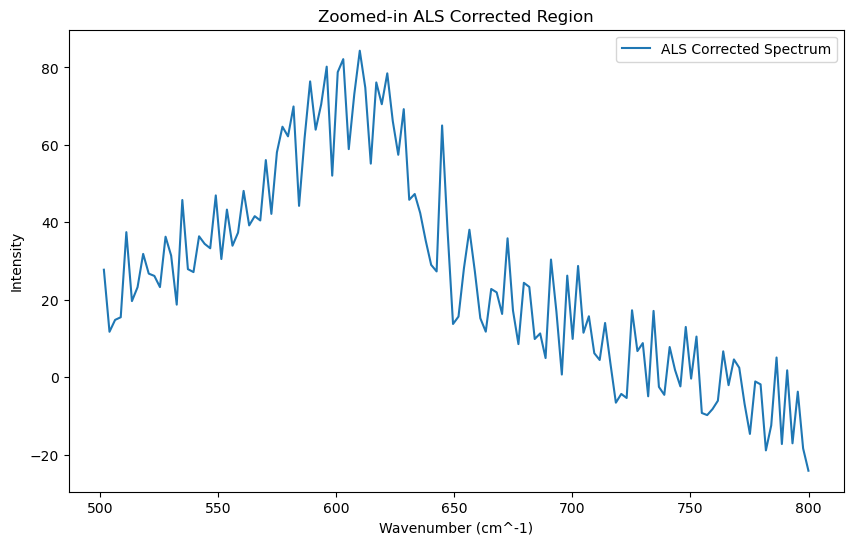

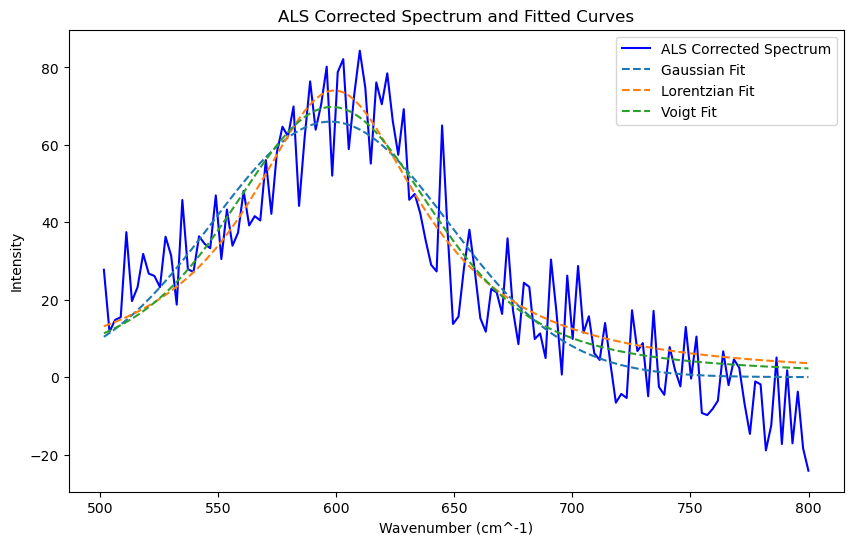

Peak Area for Gaussian fit: 8024.296352848698
Peak Area for Lorentzian fit: 8342.31958225797
Peak Area for Voigt fit: 8201.08293781251


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import special

df_test_GL = df_als.copy()

fig, ax = plt.subplots(figsize=(25, 10))
ax.plot(df_test_GL['Wavenumber'], df_test_GL['Intensity'], label='Raman Spectrum (ARPLS Corrected)')
ax.set_xlabel('Wavenumber (cm^-1)')
ax.set_ylabel('Intensity')
ax.set_title('Enter Wavenumber Range for Region of Interest')

plt.show()

start_wavenumber = float(input("Enter the start wavenumber of the region of interest (e.g., 1200): "))
end_wavenumber = float(input("Enter the end wavenumber of the region of interest (e.g., 1600): "))

region_data = df_test_GL[(df_test_GL['Wavenumber'] >= start_wavenumber) & 
                         (df_test_GL['Wavenumber'] <= end_wavenumber)]

plt.figure(figsize=(10, 6))
plt.plot(region_data['Wavenumber'], region_data['Intensity'], label='ALS Corrected Spectrum')
plt.xlabel('Wavenumber (cm^-1)')
plt.ylabel('Intensity')
plt.title('Zoomed-in ALS Corrected Region')
plt.legend()
plt.show()

def fit_multiple_gaussians(data, n_peaks=2):
    p0 = []
    for i in range(n_peaks):
        p0.extend([np.max(data['Intensity']), 
                   data['Wavenumber'].iloc[i * len(data) // n_peaks], 
                   (np.max(data['Wavenumber']) - np.min(data['Wavenumber'])) / 10])
    
    def multi_gaussian(x, *params):
        result = np.zeros_like(x)
        for i in range(n_peaks):
            A, mu, sigma = params[i*3], params[i*3+1], params[i*3+2]
            result += gaussian(x, A, mu, sigma)
        return result

    popt, _ = curve_fit(multi_gaussian, data['Wavenumber'], data['Intensity'], p0=p0)
    return popt, multi_gaussian(data['Wavenumber'], *popt)

def fit_peak(data, model='gaussian'):
    A = np.max(data['Intensity'])
    mu = data['Wavenumber'].iloc[np.argmax(data['Intensity'])]
    sigma = (np.max(data['Wavenumber']) - np.min(data['Wavenumber'])) / 10
    
    if model == 'gaussian':
        p0 = [A, mu, sigma]
        popt, _ = curve_fit(gaussian, data['Wavenumber'], data['Intensity'], p0=p0)
        return popt, gaussian(data['Wavenumber'], *popt)
    elif model == 'lorentzian':
        p0 = [A, mu, sigma]
        popt, _ = curve_fit(lorentzian, data['Wavenumber'], data['Intensity'], p0=p0)
        return popt, lorentzian(data['Wavenumber'], *popt)
    elif model == 'voigt':
        p0 = [A, mu, sigma, sigma / 2]
        popt, _ = curve_fit(voigt, data['Wavenumber'], data['Intensity'], p0=p0)
        return popt, voigt(data['Wavenumber'], *popt)
    
models = ['gaussian', 'lorentzian', 'voigt']
fitted_curves = {model: fit_peak(region_data, model=model) for model in models}

plt.figure(figsize=(10, 6))
plt.plot(region_data['Wavenumber'], region_data['Intensity'], label='ALS Corrected Spectrum', color='blue')
for model in models:
    plt.plot(region_data['Wavenumber'], fitted_curves[model][1], label=f'{model.capitalize()} Fit', linestyle='--')
plt.xlabel('Wavenumber (cm^-1)')
plt.ylabel('Intensity')
plt.title('ALS Corrected Spectrum and Fitted Curves')
plt.legend()
plt.show()

for model in models:
    peak_area = np.trapz(fitted_curves[model][1], region_data['Wavenumber'])
    print(f"Peak Area for {model.capitalize()} fit: {peak_area}")

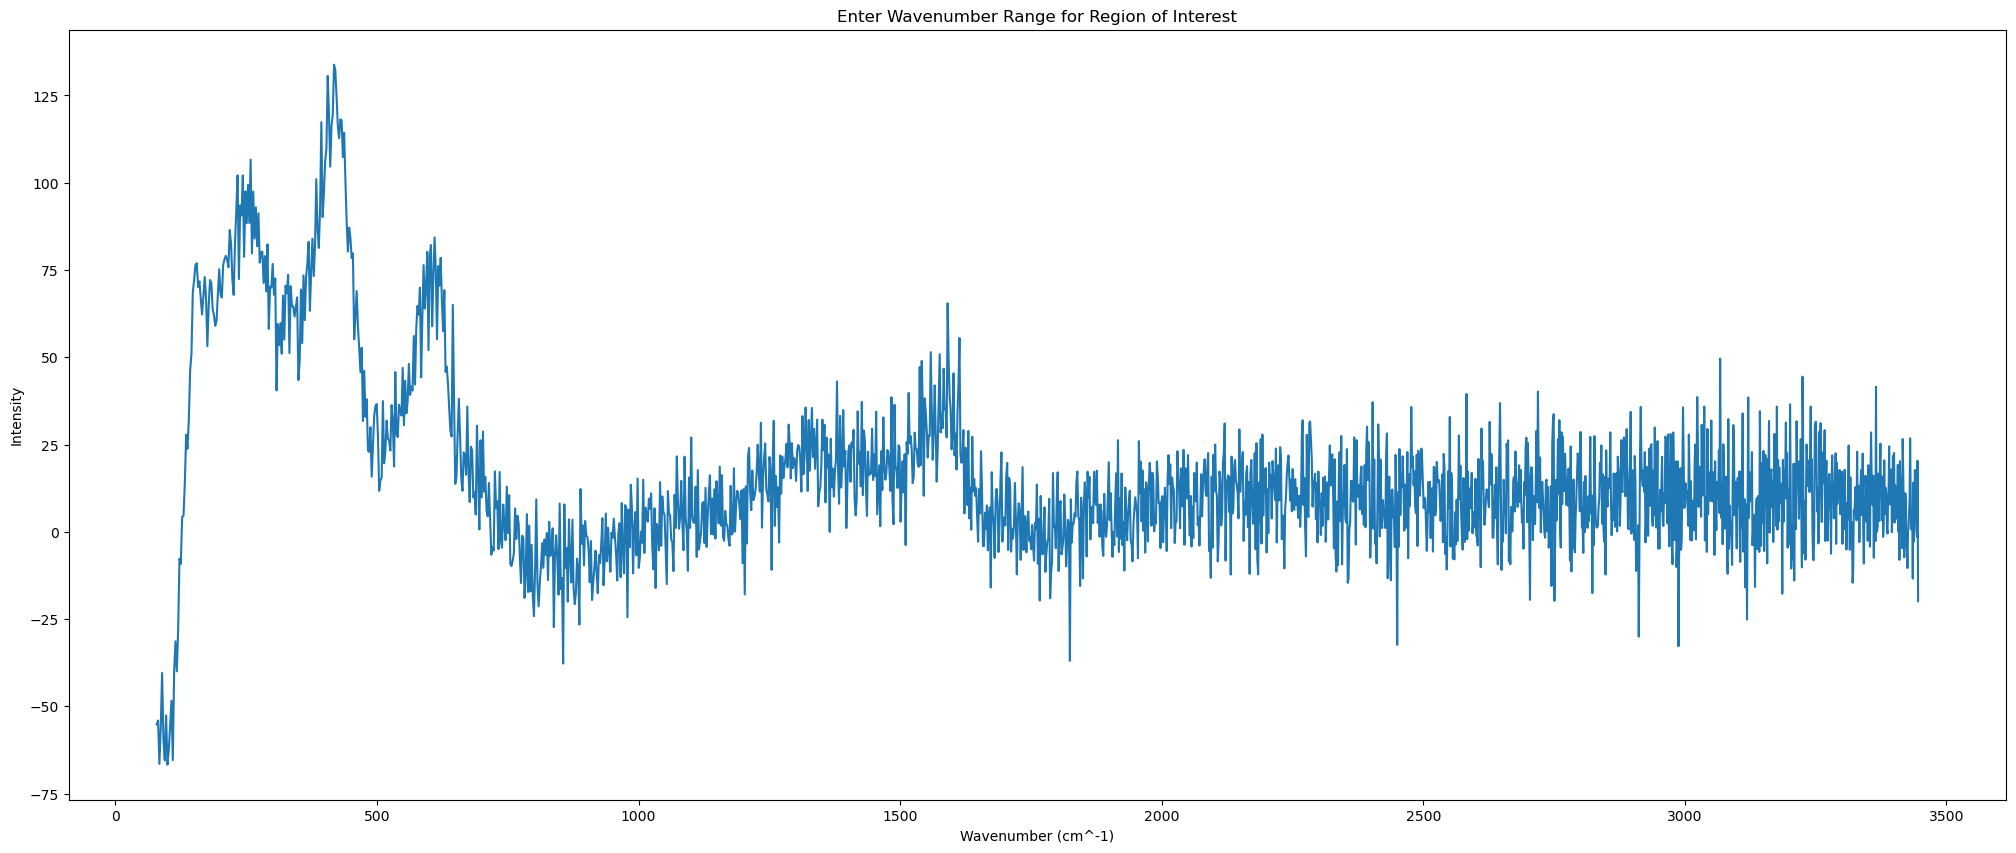

Enter the start wavenumber of the region of interest (e.g., 1200): 500
Enter the end wavenumber of the region of interest (e.g., 1600): 800
Enter the Number of Peaks in the selected region of interest: 1


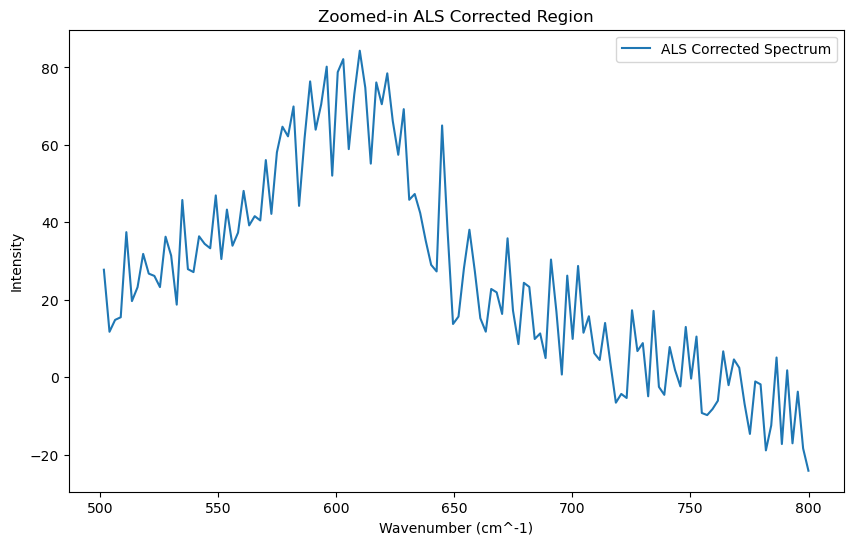

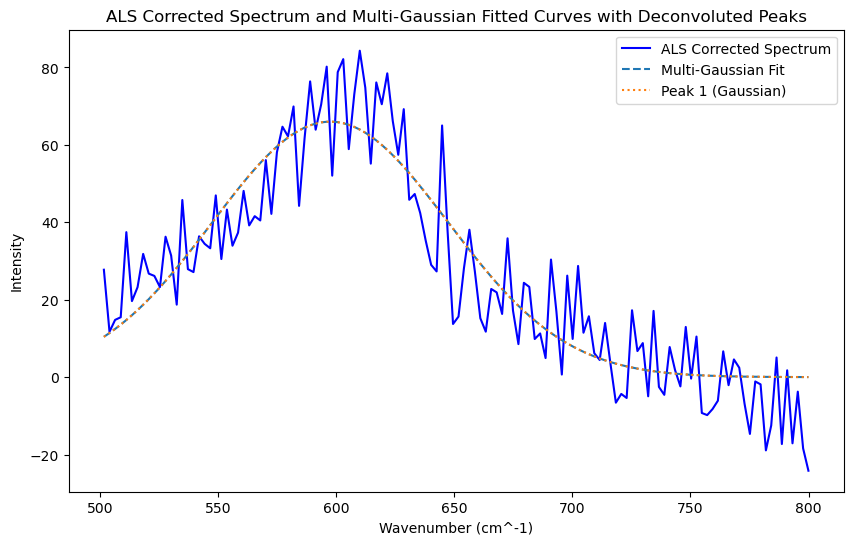

-------------Peak 1-------------
Amplitude = 66.00 (+/-) 2.19
Center = 597.56 (+/-) 1.92
FWHM = 117.43 (+/-) 4.72
Area = 8250.19
--------------------------------


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import special

df_test_GL = df_als.copy()

fig, ax = plt.subplots(figsize=(25, 10))
ax.plot(df_test_GL['Wavenumber'], df_test_GL['Intensity'], label='Raman Spectrum (ALS Corrected)')
ax.set_xlabel('Wavenumber (cm^-1)')
ax.set_ylabel('Intensity')
ax.set_title('Enter Wavenumber Range for Region of Interest')

plt.show()

start_wavenumber = float(input("Enter the start wavenumber of the region of interest (e.g., 1200): "))
end_wavenumber = float(input("Enter the end wavenumber of the region of interest (e.g., 1600): "))
num_of_peaks = int(input("Enter the Number of Peaks in the selected region of interest: "))

region_data = df_test_GL[(df_test_GL['Wavenumber'] >= start_wavenumber) & 
                         (df_test_GL['Wavenumber'] <= end_wavenumber)]

plt.figure(figsize=(10, 6))
plt.plot(region_data['Wavenumber'], region_data['Intensity'], label='ALS Corrected Spectrum')
plt.xlabel('Wavenumber (cm^-1)')
plt.ylabel('Intensity')
plt.title('Zoomed-in ALS Corrected Region')
plt.legend()
plt.show()

def gaussian(x, A, mu, sigma):
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

def fit_multiple_gaussians(data, n_peaks=2):
    p0 = []
    for i in range(n_peaks):
        p0.extend([np.max(data['Intensity']), 
                   data['Wavenumber'].iloc[i * len(data) // n_peaks], 
                   (np.max(data['Wavenumber']) - np.min(data['Wavenumber'])) / 10])

    def multi_gaussian(x, *params):
        result = np.zeros_like(x)
        for i in range(n_peaks):
            A, mu, sigma = params[i*3], params[i*3+1], params[i*3+2]
            result += gaussian(x, A, mu, sigma)
        return result

    popt, pcov = curve_fit(multi_gaussian, data['Wavenumber'], data['Intensity'], p0=p0)

    perr_gauss = np.sqrt(np.diag(pcov))
    
    return popt, perr_gauss, multi_gaussian(data['Wavenumber'], *popt)

def fit_peak(data, model='multi_gaussian', n_peaks=2):
    if model == 'multi_gaussian':
        popt, perr_gauss, fitted_curve = fit_multiple_gaussians(data, n_peaks=n_peaks)
    
    return popt, perr_gauss, fitted_curve

models = ['multi_gaussian']
fitted_curves = {}

for model in models:
    popt, perr_gauss, fitted_curve = fit_peak(region_data, model=model, n_peaks=num_of_peaks)
    fitted_curves[model] = (popt, perr_gauss, fitted_curve)

plt.figure(figsize=(10, 6))

plt.plot(region_data['Wavenumber'], region_data['Intensity'], label='ALS Corrected Spectrum', color='blue')

plt.plot(region_data['Wavenumber'], fitted_curves['multi_gaussian'][2], label='Multi-Gaussian Fit', linestyle='--')

if 'multi_gaussian' in models:
    popt, perr_gauss, _ = fitted_curves['multi_gaussian']
    for i in range(len(popt) // 3):
        A, mu, sigma = popt[i*3], popt[i*3+1], popt[i*3+2]
        peak_curve = gaussian(region_data['Wavenumber'], A, mu, sigma)
        plt.plot(region_data['Wavenumber'], peak_curve, label=f'Peak {i+1} (Gaussian)', linestyle=':')

plt.xlabel('Wavenumber (cm^-1)')
plt.ylabel('Intensity')
plt.title('ALS Corrected Spectrum and Multi-Gaussian Fitted Curves with Deconvoluted Peaks')
plt.legend()

plt.show()

for model in models:
    popt, perr_gauss, fitted_curve = fitted_curves[model]
    
    if model == 'multi_gaussian':
        n_peaks = len(popt) // 3
        for i in range(n_peaks):
            A, mu, sigma = popt[i*3], popt[i*3+1], popt[i*3+2]
            FWHM = 2 * np.sqrt(2 * np.log(2)) * sigma
            area = A * sigma * np.sqrt(2 * np.pi)

            A_err, mu_err, sigma_err = perr_gauss[i*3], perr_gauss[i*3+1], perr_gauss[i*3+2]
            
            print(f"-------------Peak {i+1}-------------")
            print(f"Amplitude = {A:.2f} (+/-) {A_err:.2f}")
            print(f"Center = {mu:.2f} (+/-) {mu_err:.2f}")
            print(f"FWHM = {FWHM:.2f} (+/-) {sigma_err * 2 * np.sqrt(2 * np.log(2)):.2f}")
            print(f"Area = {area:.2f}")
            print("--------------------------------")


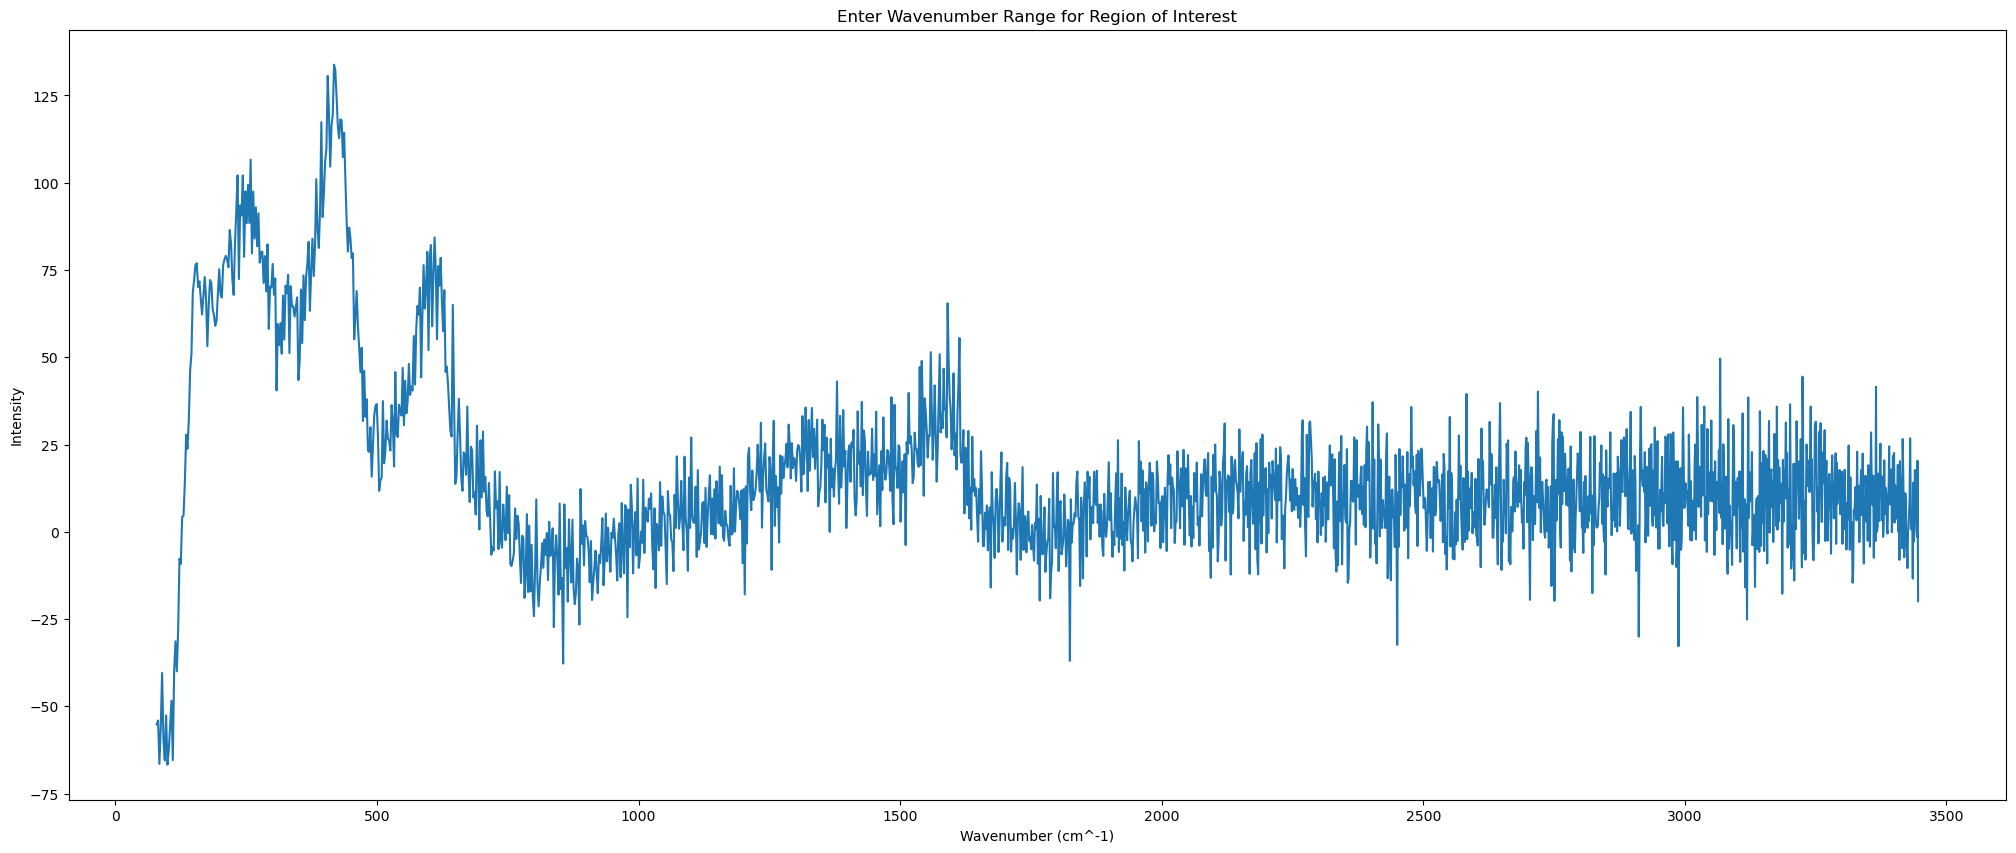

Enter the start wavenumber of the first region of interest (e.g., 1200): 170
Enter the end wavenumber of the first region of interest (e.g., 1600): 300
Enter the number of peaks in the first region of interest: 1
Enter the start wavenumber of the second region of interest (e.g., 1500): 300
Enter the end wavenumber of the second region of interest (e.g., 1900): 800
Enter the number of peaks in the second region of interest: 2


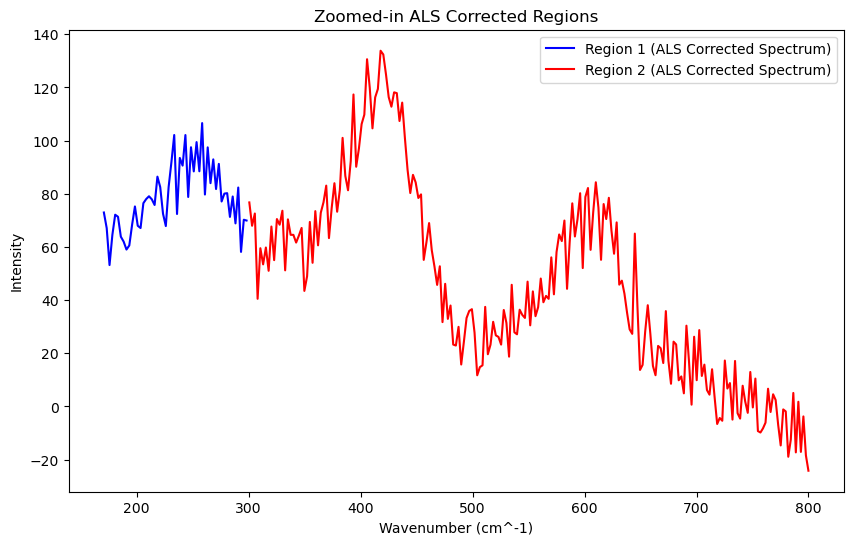

Choose the fitting model ('gaussian', multi_gaussian', 'lorentzian', 'voigt'): multi_gaussian


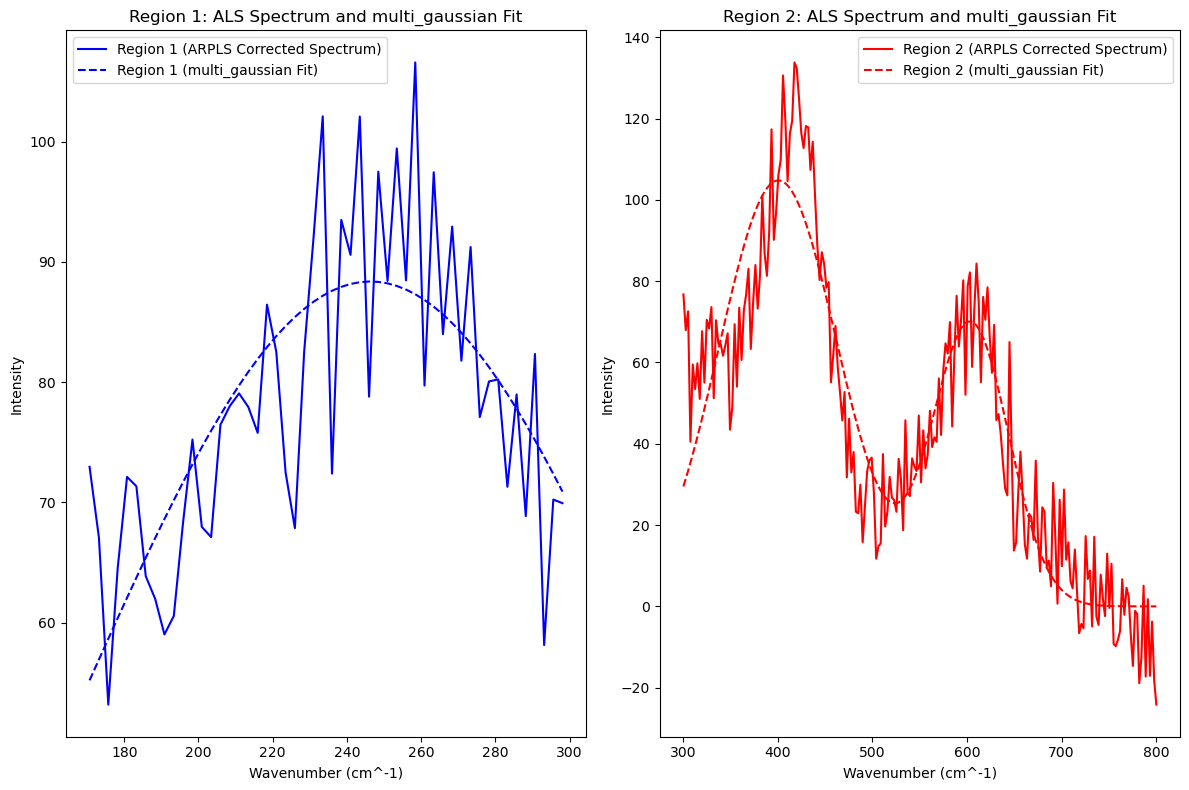

Fit error for Region 1 (multi_gaussian): 8.38
Fit error for Region 2 (multi_gaussian): 13.84
--- Region 1 Peak Details ---
Peak 1: Amplitude = 88.37, Center = 246.31, Sigma = 78.00, FWHM = 183.68
--- Region 2 Peak Details ---
Peak 1: Amplitude = 104.78, Center = 400.83, Sigma = 62.99, FWHM = 148.32
Peak 2: Amplitude = 69.50, Center = 603.72, Sigma = 40.37, FWHM = 95.07
Choose the peak index (1 to 1) from Region 1 to compare: 1
Choose the peak index (1 to 2) from Region 2 to compare: 2
Selected Peak Intensity Ratio (Region 1 / Region 2): 1.27


In [36]:
from scipy.optimize import curve_fit
from scipy import special
import numpy as np
import matplotlib.pyplot as plt

def fit_multiple_gaussians(data, n_peaks=2):
    p0 = []
    for i in range(n_peaks):
        p0.extend([np.max(data['Intensity']), 
                   data['Wavenumber'].iloc[i * len(data) // n_peaks], 
                   (np.max(data['Wavenumber']) - np.min(data['Wavenumber'])) / 10])
    
    def multi_gaussian(x, *params):
        result = np.zeros_like(x)
        for i in range(n_peaks):
            A, mu, sigma = params[i*3], params[i*3+1], params[i*3+2]
            result += gaussian(x, A, mu, sigma)
        return result

    lower_bounds = [0, np.min(data['Wavenumber']), 0] * n_peaks
    upper_bounds = [np.inf, np.max(data['Wavenumber']), np.inf] * n_peaks

    popt, pcov = curve_fit(multi_gaussian, data['Wavenumber'], data['Intensity'], p0=p0, bounds=(lower_bounds, upper_bounds))
    
    return popt, multi_gaussian(data['Wavenumber'], *popt)

def fit_peak(data, model='multi_gaussian', n_peaks=2):
    if model == 'multi_gaussian':
        popt, fitted_curve = fit_multiple_gaussians(data, n_peaks=n_peaks)
    return popt, fitted_curve
    
    A = np.max(data['Intensity'])
    mu = data['Wavenumber'].iloc[np.argmax(data['Intensity'])]
    sigma = (np.max(data['Wavenumber']) - np.min(data['Wavenumber'])) / 10

    if model == 'gaussian':
        p0 = [A, mu, sigma]
        popt, _ = curve_fit(gaussian, data['Wavenumber'], data['Intensity'], p0=p0)
        return popt, gaussian(data['Wavenumber'], *popt)

    elif model == 'lorentzian':
        p0 = [A, mu, sigma]
        popt, _ = curve_fit(lorentzian, data['Wavenumber'], data['Intensity'], p0=p0)
        return popt, lorentzian(data['Wavenumber'], *popt)

    elif model == 'voigt':
        p0 = [A, mu, sigma, sigma / 2]
        popt, _ = curve_fit(voigt, data['Wavenumber'], data['Intensity'], p0=p0, maxfev=5000)
        return popt, voigt(data['Wavenumber'], *popt)

    return None, None 

def calculate_fit_error(original, fitted):
    return np.sqrt(np.mean((original - fitted)**2))

df_test_GL = df_als.copy()

fig, ax = plt.subplots(figsize=(25, 10))
ax.plot(df_test_GL['Wavenumber'], df_test_GL['Intensity'], label='Raman Spectrum (ALS Corrected)')
ax.set_xlabel('Wavenumber (cm^-1)')
ax.set_ylabel('Intensity')
ax.set_title('Enter Wavenumber Range for Region of Interest')

plt.show()

start_wavenumber_1 = float(input("Enter the start wavenumber of the first region of interest (e.g., 1200): "))
end_wavenumber_1 = float(input("Enter the end wavenumber of the first region of interest (e.g., 1600): "))
num_of_peaks_1 = int(input("Enter the number of peaks in the first region of interest: "))

start_wavenumber_2 = float(input("Enter the start wavenumber of the second region of interest (e.g., 1500): "))
end_wavenumber_2 = float(input("Enter the end wavenumber of the second region of interest (e.g., 1900): "))
num_of_peaks_2 = int(input("Enter the number of peaks in the second region of interest: "))

region_data_1 = df_test_GL[(df_test_GL['Wavenumber'] >= start_wavenumber_1) & 
                           (df_test_GL['Wavenumber'] <= end_wavenumber_1)]
region_data_2 = df_test_GL[(df_test_GL['Wavenumber'] >= start_wavenumber_2) & 
                           (df_test_GL['Wavenumber'] <= end_wavenumber_2)]

plt.figure(figsize=(10, 6))
plt.plot(region_data_1['Wavenumber'], region_data_1['Intensity'], label='Region 1 (ALS Corrected Spectrum)', color='blue')
plt.plot(region_data_2['Wavenumber'], region_data_2['Intensity'], label='Region 2 (ALS Corrected Spectrum)', color='red')
plt.xlabel('Wavenumber (cm^-1)')
plt.ylabel('Intensity')
plt.title('Zoomed-in ALS Corrected Regions')
plt.legend()
plt.show()

chosen_model = input("Choose the fitting model ('gaussian', multi_gaussian', 'lorentzian', 'voigt'): ")

popt_1, fitted_curve_1 = fit_peak(region_data_1, model=chosen_model, n_peaks=num_of_peaks_1)
popt_2, fitted_curve_2 = fit_peak(region_data_2, model=chosen_model, n_peaks=num_of_peaks_2)

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(region_data_1['Wavenumber'], region_data_1['Intensity'], label=f'Region 1 (ARPLS Corrected Spectrum)', color='blue')
plt.plot(region_data_1['Wavenumber'], fitted_curve_1, label=f'Region 1 ({chosen_model} Fit)', linestyle='--', color='blue')
plt.xlabel('Wavenumber (cm^-1)')
plt.ylabel('Intensity')
plt.title(f'Region 1: ALS Spectrum and {chosen_model} Fit')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(region_data_2['Wavenumber'], region_data_2['Intensity'], label=f'Region 2 (ARPLS Corrected Spectrum)', color='red')
plt.plot(region_data_2['Wavenumber'], fitted_curve_2, label=f'Region 2 ({chosen_model} Fit)', linestyle='--', color='red')
plt.xlabel('Wavenumber (cm^-1)')
plt.ylabel('Intensity')
plt.title(f'Region 2: ALS Spectrum and {chosen_model} Fit')
plt.legend()

plt.tight_layout()
plt.show()

fit_error_1 = calculate_fit_error(region_data_1['Intensity'], fitted_curve_1)
fit_error_2 = calculate_fit_error(region_data_2['Intensity'], fitted_curve_2)

print(f"Fit error for Region 1 ({chosen_model}): {fit_error_1:.2f}")
print(f"Fit error for Region 2 ({chosen_model}): {fit_error_2:.2f}")

def display_peak_details(popt, region_name):
    num_peaks = len(popt) // 3
    print(f"--- {region_name} Peak Details ---")
    for i in range(num_peaks):
        A, mu, sigma = popt[i*3], popt[i*3+1], popt[i*3+2]

        FWHM = 2 * np.sqrt(2 * np.log(2)) * sigma  
        print(f"Peak {i+1}: Amplitude = {A:.2f}, Center = {mu:.2f}, Sigma = {sigma:.2f}, FWHM = {FWHM:.2f}")
    return num_peaks

num_peaks_1 = display_peak_details(popt_1, "Region 1")
num_peaks_2 = display_peak_details(popt_2, "Region 2")

peak_1_idx = int(input(f"Choose the peak index (1 to {num_peaks_1}) from Region 1 to compare: ")) - 1
peak_2_idx = int(input(f"Choose the peak index (1 to {num_peaks_2}) from Region 2 to compare: ")) - 1

intensity_1 = popt_1[peak_1_idx*3] 
intensity_2 = popt_2[peak_2_idx*3] 

intensity_ratio = intensity_1 / intensity_2
print(f"Selected Peak Intensity Ratio (Region 1 / Region 2): {intensity_ratio:.2f}")


In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy import special

def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def lorentzian(x, A, mu, gamma):
    return A * (gamma**2) / ((x - mu)**2 + gamma**2)

def voigt(x, A, mu, sigma, gamma):
    return np.real(A * special.wofz((x - mu + 1j*gamma) / sigma) / (sigma * np.sqrt(2 * np.pi)))

def fit_multiple_gaussians(data, n_peaks, intensity_column):
    p0 = []
    for i in range(n_peaks):
        p0.extend([np.max(data[intensity_column]), 
                   data['Wavenumber'].iloc[i * len(data) // n_peaks], 
                   (np.max(data['Wavenumber']) - np.min(data['Wavenumber'])) / 10])
    
    def multi_gaussian(x, *params):
        result = np.zeros_like(x)
        for i in range(n_peaks):
            A, mu, sigma = params[i*3], params[i*3+1], params[i*3+2]
            result += gaussian(x, A, mu, sigma)
        return result

    lower_bounds = [0, np.min(data['Wavenumber']), 0] * n_peaks
    upper_bounds = [np.inf, np.max(data['Wavenumber']), np.inf] * n_peaks

    popt, _ = curve_fit(multi_gaussian, data['Wavenumber'], data[intensity_column], p0=p0, bounds=(lower_bounds, upper_bounds))
    return popt, multi_gaussian(data['Wavenumber'], *popt)

def fit_peak(data, model, n_peaks, intensity_column):
    if model == 'multi_gaussian':
        return fit_multiple_gaussians(data, n_peaks, intensity_column)
    elif model == 'gaussian':
        p0 = [np.max(data[intensity_column]), np.mean(data['Wavenumber']), 10]
        popt, _ = curve_fit(gaussian, data['Wavenumber'], data[intensity_column], p0=p0)
        return popt, gaussian(data['Wavenumber'], *popt)
    elif model == 'lorentzian':
        p0 = [np.max(data[intensity_column]), np.mean(data['Wavenumber']), 10]
        popt, _ = curve_fit(lorentzian, data['Wavenumber'], data[intensity_column], p0=p0)
        return popt, lorentzian(data['Wavenumber'], *popt)
    elif model == 'voigt':
        p0 = [np.max(data[intensity_column]), np.mean(data['Wavenumber']), 10, 10]
        popt, _ = curve_fit(voigt, data['Wavenumber'], data[intensity_column], p0=p0)
        return popt, voigt(data['Wavenumber'], *popt)
    else:
        raise ValueError("Unsupported model type")

results = []
if not frame_columns:
    print("No valid frame intensity columns found. Please check the dataset.")
else:
    for frame in frame_columns:
        print(f"\nProcessing {frame}...")
        current_frame_data = df_test_GL[['Wavenumber', frame]].dropna()

        region_data_1 = current_frame_data[(current_frame_data['Wavenumber'] >= start_wavenumber_1) & 
                                           (current_frame_data['Wavenumber'] <= end_wavenumber_1)]
        region_data_2 = current_frame_data[(current_frame_data['Wavenumber'] >= start_wavenumber_2) & 
                                           (current_frame_data['Wavenumber'] <= end_wavenumber_2)]

        if region_data_1.empty or region_data_2.empty:
            print(f"Skipping {frame}: Insufficient data in one or both regions.")
            continue
        
        popt_1, _ = fit_peak(region_data_1, chosen_model, num_peaks_1, frame)
        popt_2, _ = fit_peak(region_data_2, chosen_model, num_peaks_2, frame)
        
        for i in range(min(num_peaks_1, num_peaks_2)):
            intensity_ratio = popt_1[i*3] / popt_2[i*3] if popt_2[i*3] != 0 else np.nan
            results.append({
                'Frame': frame,
                'Peak Region 1 Intensity': popt_1[i*3],
                'Peak Region 1 Center (Wavenumber)': popt_1[i*3+1],
                'Peak Region 1 FWHM': 2.355 * popt_1[i*3+2],
                'Peak Region 2 Intensity': popt_2[i*3],
                'Peak Region 2 Center (Wavenumber)': popt_2[i*3+1],
                'Peak Region 2 FWHM': 2.355 * popt_2[i*3+2],
                'Peak Intensity Ratio (Region 1 / Region 2)': intensity_ratio
            })

results_df = pd.DataFrame(results)
filename = f'peak_intensity_comparison_{start_wavenumber_1}_{end_wavenumber_1}_vs_{start_wavenumber_2}_{end_wavenumber_2}_{chosen_model}.xlsx'

if not results_df.empty:
    results_df.to_excel(filename, index=False)
    print("\nPeak intensity ratios have been calculated and exported to Excel.")
else:
    print("\nNo peaks detected or valid data. No file was created.")
